In [1]:
%matplotlib inline
%load_ext autoreload
%config InlineBackend.figure_format = 'retina' # high res plotting
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

# import os 
# import h5py

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-qlguy406 because the default path (/home/debrown/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import scipy
import seaborn as sns
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

fontprops = fm.FontProperties(size=18)


In [3]:
# Import from BirdSongToolbox
from BirdSongToolbox.import_data import ImportData
import BirdSongToolbox.free_epoch_tools as fet
from BirdSongToolbox.file_utility_functions import _load_pckl_data


In [4]:
from BirdSongToolbox.behave.behave_utils import event_array_maker_chunk, get_events_rasters, repeat_events


In [5]:
import sys

#file structure for /src
package_folder = '/home/debrown/Songbird-LFP-Paper/'
sys.path.append(package_folder)

In [6]:
# Import the new package made specifically for this analysis

from src.analysis.chunk_when_analysis_naive import load_pandas_from_pickle, all_when_label_instructions 
from src.analysis.chunk_when_analysis_naive import motif_length_dict, collaspse_folds

from src.analysis.ml_pipeline_utilities import all_bad_channels, all_drop_temps, all_label_instructions
from src.analysis.context_utility import birds_context_obj
from src.analysis.chunk_feature_dropping_pearson import best_bin_width, best_offset


In [7]:
import src.analysis.chunk_when_analysis_naive as cwan


In [93]:
# # Path to saving Figures

# from src.utils.paths import FIGURES_DIR


In [9]:
# Designate the High Yield Days for Each Bird

z020_days = ['day-2016-06-03', 'day-2016-06-05']
z007_days = ['day-2016-09-10','day-2016-09-11']
z017_days = ['day-2016-06-19', 'day-2016-06-21']

In [10]:
# Data Source for Branch Point Anlaysis 
branch_analysis_path = "/home/debrown/branch_analysis_path"

# Data Source for Script Original Naive Onset Detection
onset_detection_path = '/home/debrown/onset_detection_results'

# z007

In [11]:
z007_bird_id = 'z007'

z007_holder = []
for index, z007_session in enumerate(z007_days):
    z007_composite_results = load_pandas_from_pickle(data_name="composite_results_run_2", bird_id=z007_bird_id, 
                                                     session=z007_session, source=onset_detection_path, verbose=True)
    z007_composite_results['session'] = f"Day {index +1}"
    z007_holder.append(z007_composite_results)
full_results_z007 = pd.concat(z007_holder, axis=0)


Loading from composite_results_run_2 Data to composite_results_run_2.pckl
Loading from composite_results_run_2 Data to composite_results_run_2.pckl


In [68]:
# Save the Motif Ledger
z007_election_results = _load_pckl_data(data_name="election_results_run_2", bird_id=z007_bird_id, session=z007_session, 
                                        source=onset_detection_path, verbose=True)

# Save the Motif Ledger
z007_stereotyped_starts = _load_pckl_data(data_name="stereotyped_starts_run_2", bird_id=z007_bird_id, session=z007_session, 
                                          source=onset_detection_path, verbose=True)


Loading from election_results_run_2 Data to election_results_run_2.pckl
Loading from stereotyped_starts_run_2 Data to stereotyped_starts_run_2.pckl


In [12]:
full_results_z007.head()

,times,Freq_band,Syllable,session
0,0.300000,4-8,2,Day 1
1,1.033333,4-8,2,Day 1
2,4.566667,4-8,2,Day 1
3,13.133333,4-8,2,Day 1
4,5.033333,4-8,2,Day 1


# Import Relevant Data for z007

In [13]:
# How this should actually be imported
# from src.analysis.chunk_when_analysis_naive import all_when_label_instructions, motif_length_dict

# Bird's Default Class Labels
all_when_label_instructions = cwan.all_when_label_instructions 


# Make Motif Length Times for the analysis
motif_length_dict = cwan.motif_length_dict 

In [14]:
# Save the DataFrame of Onset Results
bird_id = "z007"
session = 'day-2016-09-11'


In [15]:


z007_day2_fmo = _load_pckl_data(data_name="full_motif_organized", bird_id=bird_id, session=session, 
                                source=branch_analysis_path, verbose=True)

z007_day2_fms = _load_pckl_data(data_name="full_motif_starts", bird_id=bird_id, session=session, 
                                source=branch_analysis_path, verbose=True)

# Save the Motif Ledger
motif_ledger = _load_pckl_data(data_name="motif_ledger_run_2", bird_id=bird_id,
                                    session=session, source=onset_detection_path, verbose=True)

Loading from full_motif_organized Data to full_motif_organized.pckl
Loading from full_motif_starts Data to full_motif_starts.pckl
Loading from motif_ledger_run_2 Data to motif_ledger_run_2.pckl


## Copy over the spectrogram functions

In [16]:
import matplotlib 

In [17]:
# Copying the Spectrogram Function
def spectrogram(x, s_f, cut_off=1, window=None, n_perseg=None, n_overlap=None, sigma=0.3, nfft=None):
    if window is None:
        window = scipy.signal.gaussian(n_perseg, sigma)

    f, t, s = scipy.signal.spectrogram(np.transpose(x), fs=s_f, window=window,
                                       nperseg=n_perseg,
                                       noverlap=n_overlap,
                                       nfft=nfft,
                                       detrend='constant', return_onesided=True,
                                       scaling='density', axis=-1, mode='psd')

    # Apply Threshold to the Spectrogram
    s[s < cut_off] = cut_off

    return f, t, s

# From Zeke
def normalize(u, axis=0):
    # normalize to (0-1) along axis
    # (axis=0 to normalize every col to its max value, axis=0 to normalize every row to its max value)
    u_max = np.repeat(np.amax(u, axis=axis, keepdims=True), u.shape[axis], axis=axis)
    # print(u_max.shape)
    u_min = np.repeat(np.amin(u, axis=axis, keepdims=True), u.shape[axis], axis=axis)

    u_range = u_max - u_min
    u_range[u_range==0] = 1 # prevent nans, if range is zero set the value to 1.
    return (u - u_min)/u_range

# Adapted From Zeke
def my_spectrogram(Audio, s_f=30000, step_s=.001, window=None, n_perseg=192, f_cut=1, nfft=None, sigma=40):

    n_overlap = n_perseg - int(s_f * step_s)

    f, t, s = spectrogram(Audio, s_f=s_f, cut_off=f_cut, window=window, n_perseg=n_perseg, n_overlap=n_overlap,
                          sigma=sigma, nfft=nfft)

    s_normalized = normalize(np.log(s), axis=-1)
    return f, t, s_normalized

In [18]:
def plot_mean_w_std(trials, times, times_labels=None, color = 'green', linewidth= None,  ax=None):
    """
    trials: ndarray | (samples, trials) 
    times: ndarray | (samples,) 
    ax=None
    """
    
    mean_trace = np.mean(trials, axis=-1)
    std_trace = np.std(trials, ddof=1, axis=-1)

    
    if ax is None:
        plt.plot(times, mean_trace, color = color, linewidth=linewidth)
        plt.fill_between(x=times, y1=mean_trace +std_trace, y2=mean_trace-std_trace, color = color, alpha=.5)
        plt.ylim(0, max_len)

    else:
        ax.plot(times, mean_trace, color = color, linewidth=linewidth,)
        ax.fill_between(x=times, y1=mean_trace +std_trace, y2=mean_trace-std_trace, color = color, alpha=.5)

-------

In [19]:
# Import the Data
zdata = ImportData(bird_id=bird_id, session=session)

In [20]:
# Reshape Handlabels into Useful Format
chunk_labels_list, chunk_onsets_list = fet.get_chunk_handlabels(handlabels_list=zdata.song_handlabels)

In [21]:
motif_length = motif_length_dict[bird_id]



In [22]:
# Get the Bird Specific label Instructions
label_instructions = all_label_instructions[bird_id]  # get this birds default label instructions

times_of_interest = fet.label_extractor(all_labels=chunk_labels_list,
                                        starts=chunk_onsets_list[0],
                                        label_instructions=label_instructions)

In [23]:
# fet.event_clipper_nd()

clipped_audio_all = fet.event_clipper_nd(data= zdata.song_audio, label_events=times_of_interest, fs=30000, window=(0, motif_length))
clipped_audio = clipped_audio_all[0]

In [24]:
# Create timeseries representing the labeled Events For all Chunks
event_array_test2 = event_array_maker_chunk(labels_list=chunk_labels_list, onsets_list=chunk_onsets_list)


In [25]:
all_motif_behave = get_events_rasters(data=event_array_test2, indices=times_of_interest[0], fs=1000, 
                                  window=(0, motif_length))


In [26]:
# Get the Behavior for only the full Motifs
full_motif_behave = all_motif_behave[motif_ledger[5],:]
np.shape(full_motif_behave)

(98, 750)

In [27]:
# Get the Audio for only the full Motifs
full_motif_audio = clipped_audio[motif_ledger[5],:]
np.shape(full_motif_audio)

(98, 22500)

In [28]:
full_motif_starts = z007_day2_fms

full_motif_organized = z007_day2_fmo



In [58]:
# repeat_events??
def repeat_motif_events(labels_array, set_width=400):
    """ Repeat Instances for creating visualization of Behavior

    Parameters
    ----------
    labels_array : ndarray | (samples,)
        Array of the Events to be repeated for Visualization

    Returns
    -------
    set_array : ndarray | shape (400, Samples)
        Array of the Events ready for visualization
    """
    window_width = len(labels_array)  # Get the length of the Array
    num_repeats = set_width
    steps = np.arange(0, set_width)  
    set_array = np.zeros((set_width, window_width))  # Create Empty Array

    for inst in steps:
        set_array[inst, :] = labels_array
    return set_array

In [31]:
cmap2 = matplotlib.colors.ListedColormap(
    ['#000000', '#B66DFF', '#db6e00', '#009292', '#924900', '#006DDB', '#B6DBFF', 'white', '#feb4d9', '#490092'])
cmap2.set_over('cyan')
cmap2.set_under('#B6DBFF')
bounds = [.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap2.N)


In [70]:
max_confidence = 150
time_buffer = 50

In [33]:
subsize = 8
bigsize = 12
ticksize = 8
line_width = .5

In [55]:
selection = 4


sel_rel_starts = full_motif_starts[selection]
exemplar_predictions = full_motif_organized[selection, :,:]
sel_behave = full_motif_behave[selection,:]

sel_audio = full_motif_audio[selection,:]

f2, t2, s2 = my_spectrogram(sel_audio, f_cut=.5, nfft=200)



/home/debrown/anaconda3/envs/mne/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


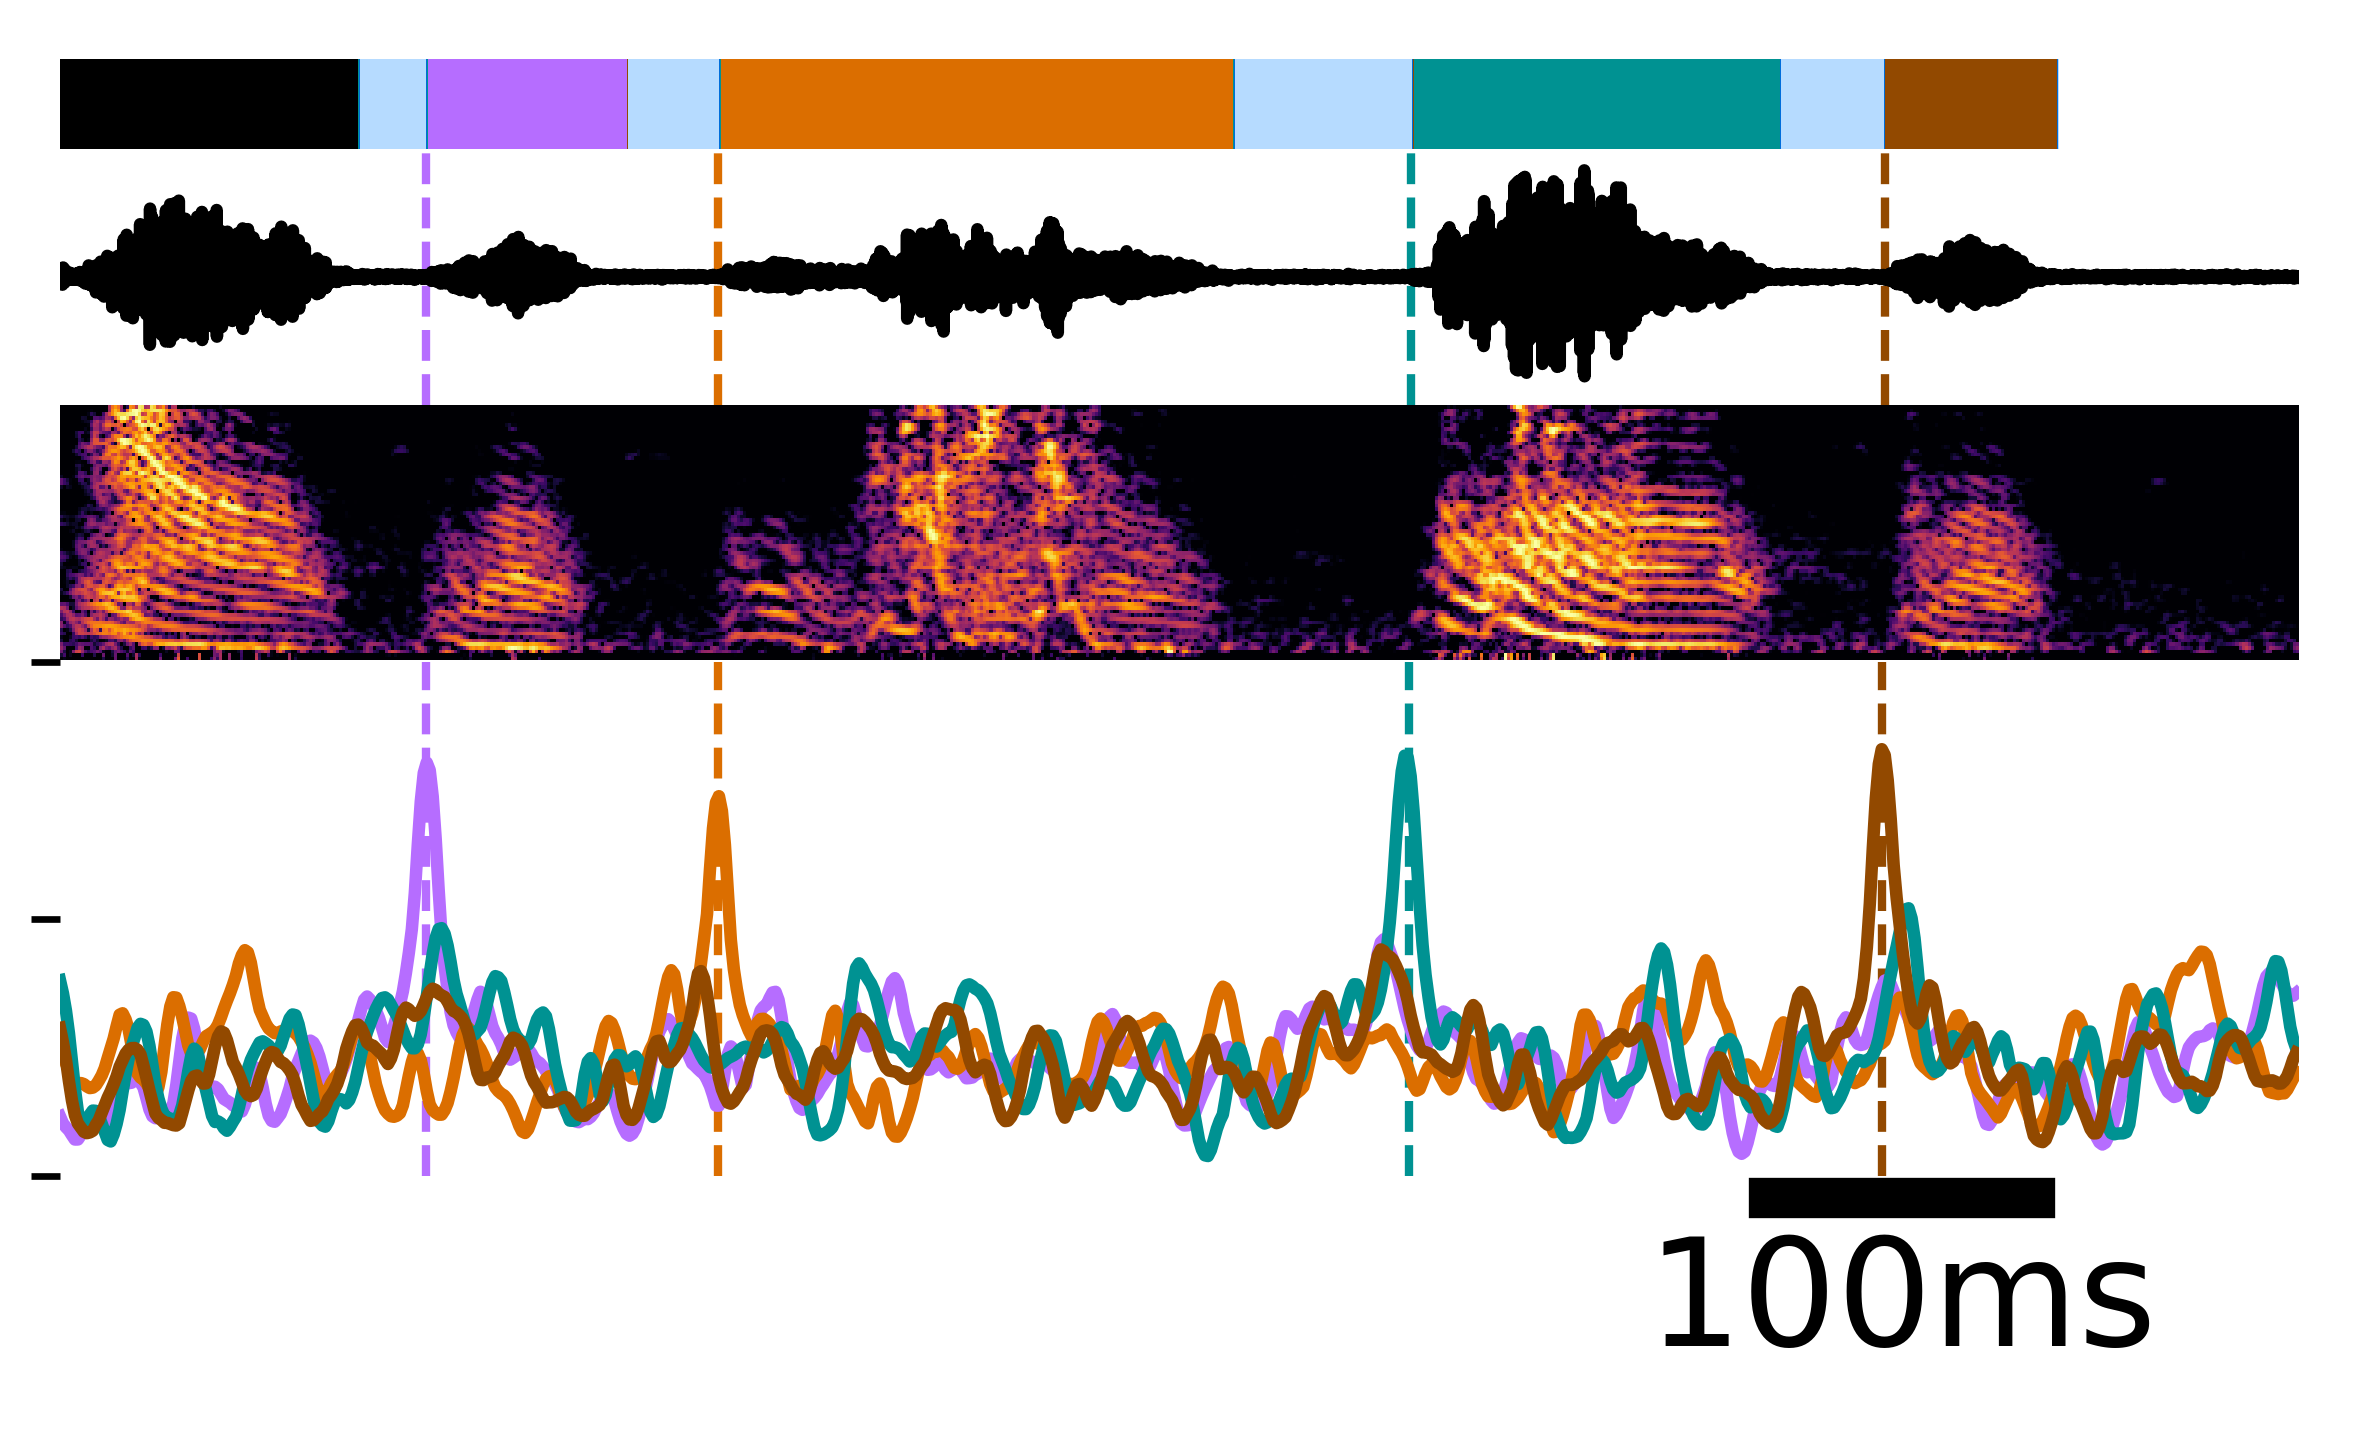

In [59]:
# Note: Make the Duration of the song and the asociated limits be automatically pulled from the birds metadata

fig = plt.figure(figsize=(4,3), dpi = 300)


# Make the Subplots
# Color Labels
ax1 = fig.add_axes([0.0333, 0.60641, 0.933, 0.05], frame_on=False, xticklabels=[],)
# Pressure Waveform
ax2 = fig.add_axes([0.0333, 0.46441, 0.933, 0.142], frame_on=False, xticklabels=[], ylim=(-1.2, 1.2))
# Spectrogram
ax3 = fig.add_axes([0.0333, 0.32241, 0.933, .142], frame_on=False, xticklabels=[],  ylim=(-1.2, 1.2))
ax4 = fig.add_axes([0.0333, 0.0357, 0.933, 0.28571], frame_on=False, xticklabels=[], ylim=(-1.2, 1.2))


# colors= {1:'black',2:'blue',3:'orange', 4:'green' ,5:'red', 6:'blue', 7:'white', 8:'white','I':'pink', 'C':'purple', 'BUFFER': 'white'}

colors= {1:'#000000',2:'#B66DFF',3:'#db6e00', 4:'#009292' ,5:'#924900', 6:'#006DDB', 7:'#FFFF6D', 9:'#B6DBFF',
         8:'white','I':'#feb4d9', 'C':'#490092', 'BUFFER': 'white'}

repeated_behave = repeat_motif_events(labels_array= sel_behave)
ax1.imshow(repeated_behave, cmap=cmap2, Norm=norm, aspect="auto")

# ax1.set_xlim(0,.9)


for start, label in zip(sel_rel_starts, [2,3,4,5, 6, 7]):
        color = colors[label]
#         print(start)
#         print(start/30000)
        ax2.axvline(x=start/30000, linestyle='--', color=color, linewidth=line_width*2)
        ax4.axvline(x=start/30, linestyle='--', color=color, linewidth=line_width*2)
        
ax1.get_yaxis().set_visible(False)  # Hide the Y axis
ax1.get_xaxis().set_visible(False)  # Hide the Y axis

# Audio Pressure Waveform
timeseries_audio = sel_audio/np.max(sel_audio)
timeseries_length = len(timeseries_audio)/30000  # Convert x to seconds
ax2.plot(np.arange(0, timeseries_length, 1/30000), timeseries_audio, color = "black")
ax2.get_yaxis().set_visible(False)  # Hide the Y axis
ax2.get_xaxis().set_visible(False)  # Hide the Y axis
    
ax2.set_xlim(0,.75)


# Plot the Spectrogram
sns.heatmap(s2, xticklabels=False, yticklabels= False, cbar = False, cmap= 'inferno', ax = ax3)
ax3.invert_yaxis()
ax3.set_ylim((0,70))


for predict_slam, color in zip(exemplar_predictions, ['#B66DFF','#db6e00','#009292','#924900','#006DDB','#FFFF6D']):
    ax4.plot(np.arange(751), predict_slam/max_confidence, color = color)

ax4.set_ylim(0, 1)
ax4.set_xlim(0, 751)
# ax4.get_yaxis().set_visible(False)  # Hide the Y axis
ax4.set_yticklabels([])
ax4.get_xaxis().set_visible(False)  # Hide the Y axis

#

# Add a Scale Bar
scalebar = AnchoredSizeBar(ax2.transData,
                           .1, '100ms', 'center right', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=.3,
                           fontproperties=fontprops, bbox_to_anchor=(.95, -.2),
                           bbox_transform=ax4.transAxes)

ax4.add_artist(scalebar)

plt.show()

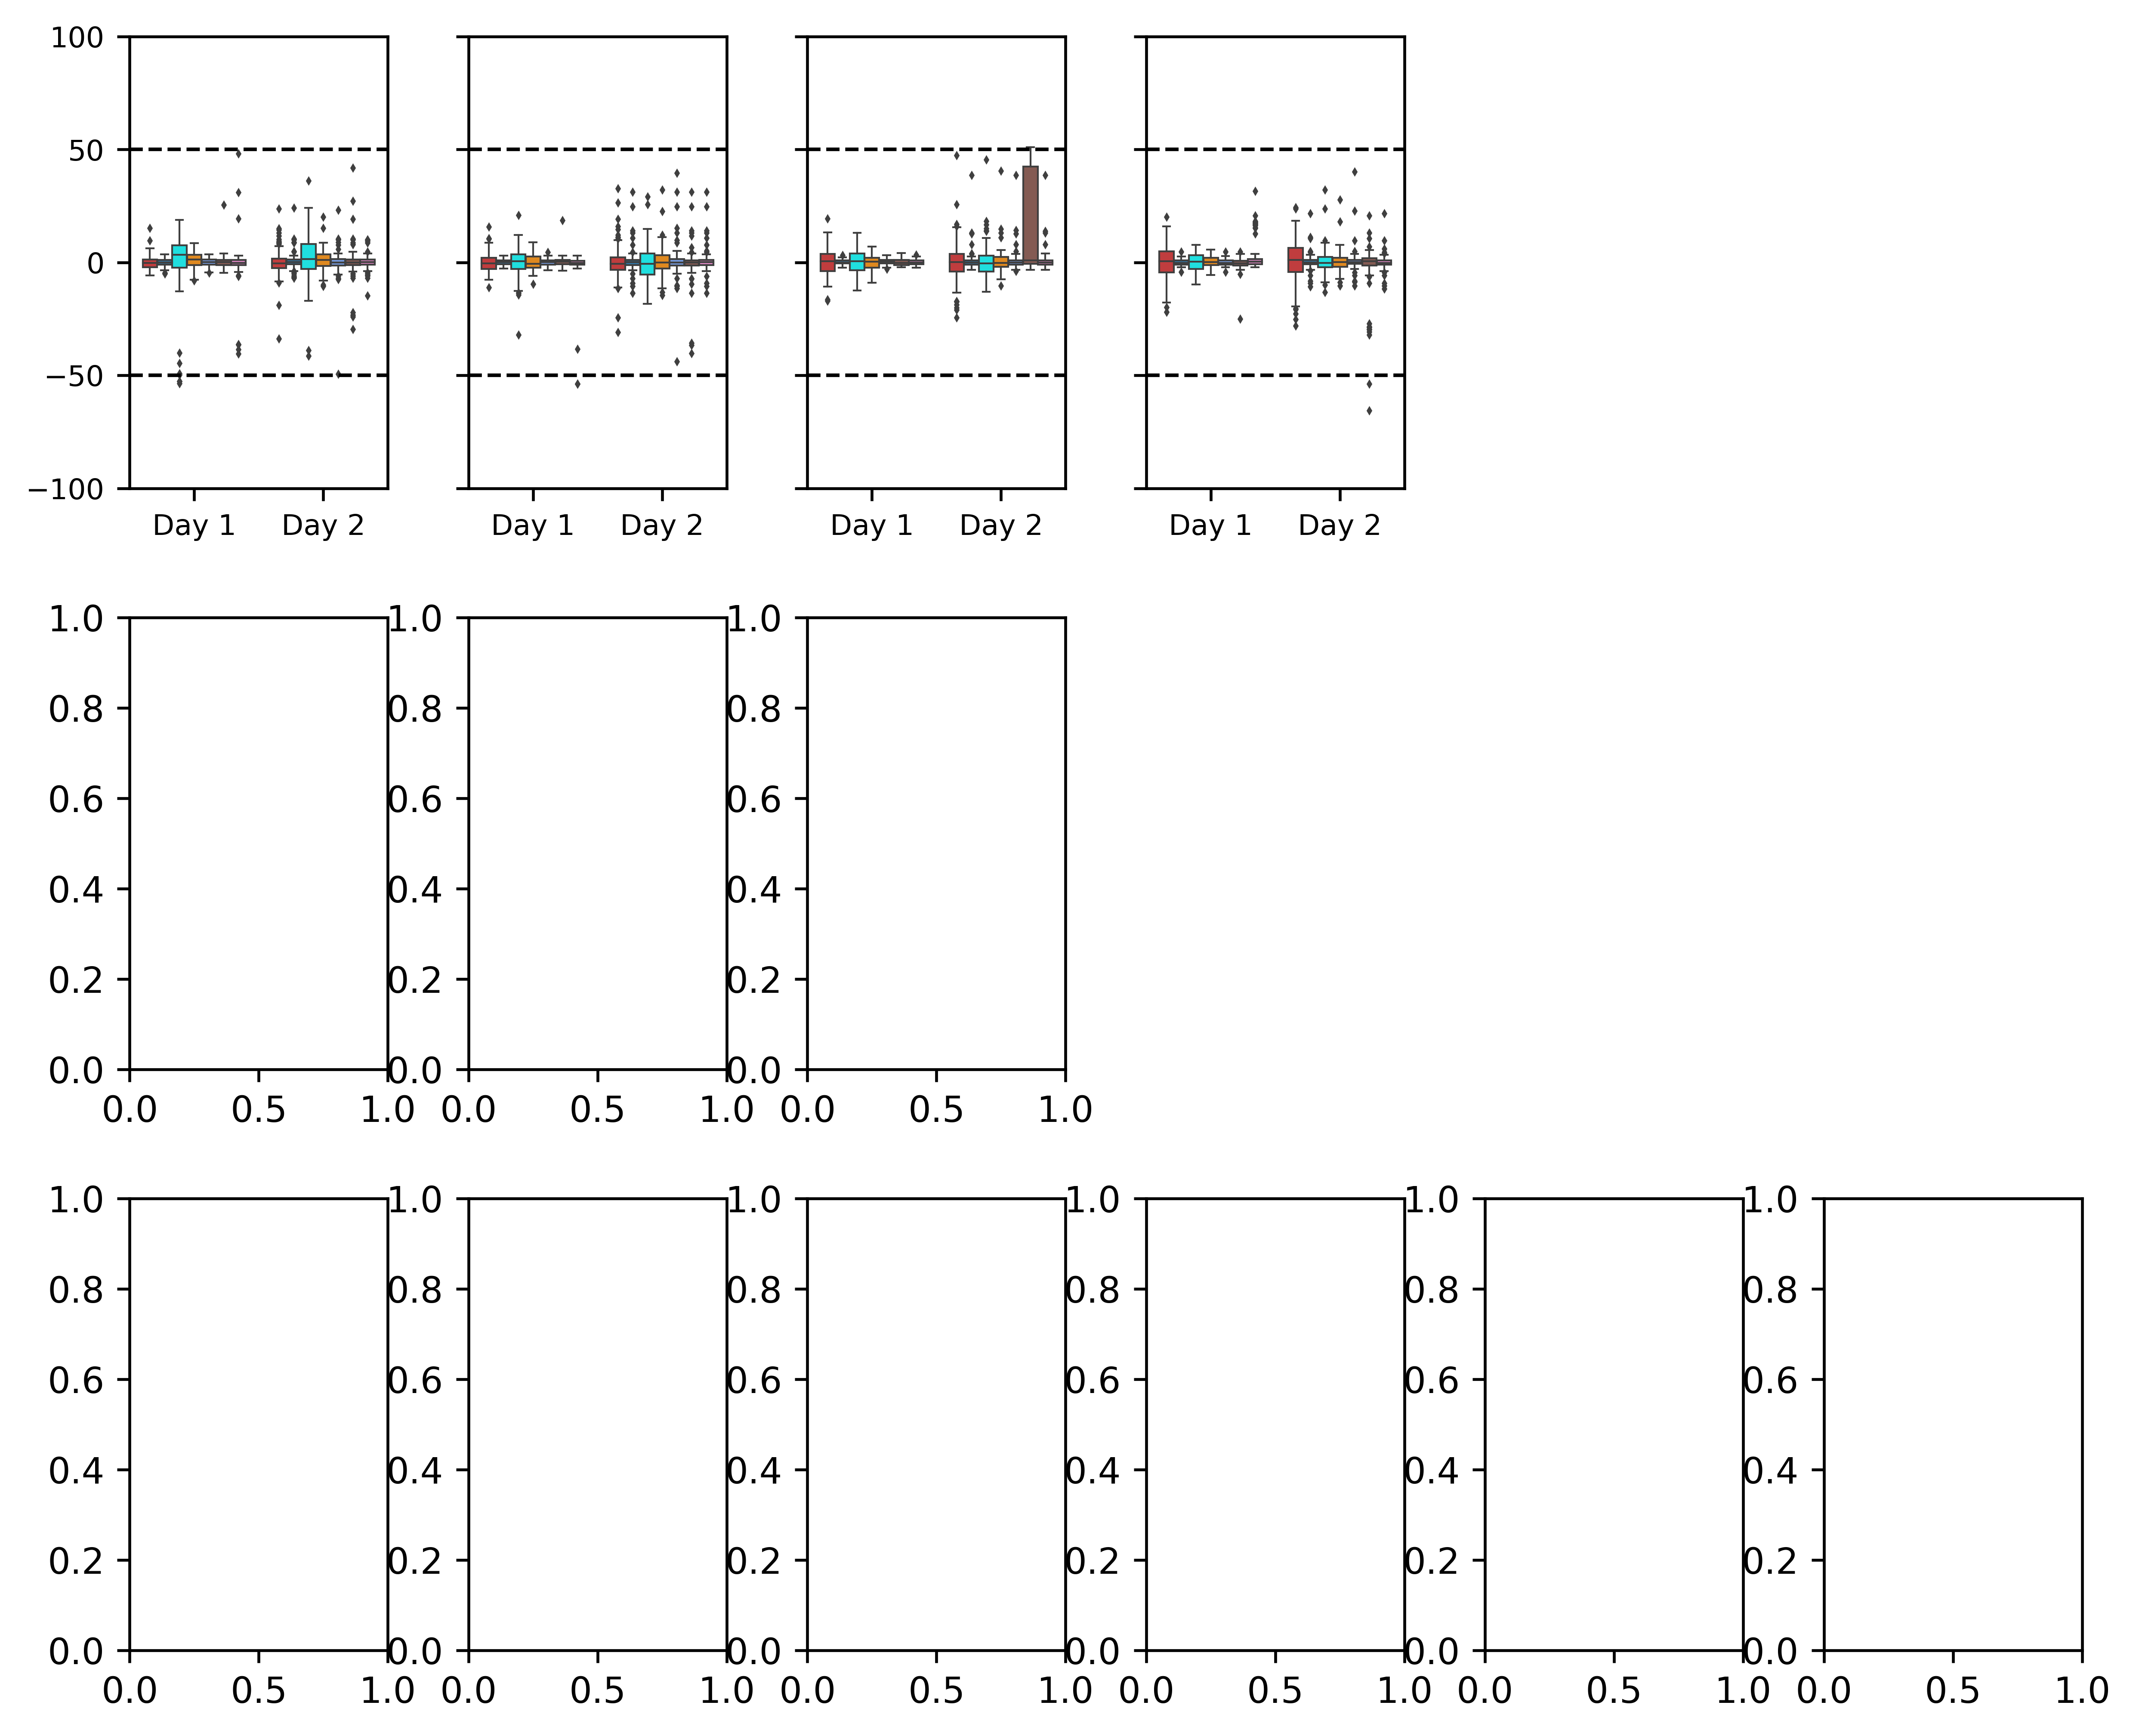

In [94]:
fig = plt.figure(figsize=(8.5, 7), dpi = 300)

freq_colors = [ 'tab:red', 'tab:blue', 'aqua', 'darkorange', 'cornflowerblue', 'tab:brown', 'tab:pink']

line_width = .5
subsize = 8
bigsize = 12
ticksize = 8

# z020_days = ['day-2016-06-03', 'day-2016-06-05']
# z007_days = ['day-2016-09-10','day-2016-09-11']
# z017_days = ['day-2016-06-19', 'day-2016-06-21']


# z017
syll_2_z017 = fig.add_axes([0.05882, 0.07142, 0.117647, 0.25]) 
syll_3_z017 = fig.add_axes([0.21323, 0.07142, 0.117647, 0.25]) # z017
syll_4_z017 = fig.add_axes([0.367634, 0.07142, 0.117647, 0.25]) # z017
syll_5_z017 = fig.add_axes([0.522041, 0.07142, 0.117647, 0.25]) 
syll_6_z017 = fig.add_axes([0.676448, 0.07142, 0.117647, 0.25]) 
syll_7_z017 = fig.add_axes([0.830854, 0.07142, 0.117647, 0.25]) 

# z020
syll_2_z020 = fig.add_axes([0.05882, 0.392839, 0.117647, 0.25]) 
syll_3_z020 = fig.add_axes([0.21323, 0.392839, 0.117647, 0.25]) # z017
syll_4_z020 = fig.add_axes([0.367634, 0.392839, 0.117647, 0.25]) # z017


# z007
syll_2_z007 = fig.add_axes([0.05882, 0.714259, 0.117647, 0.25]) 
syll_3_z007 = fig.add_axes([0.21323, 0.714259, 0.117647, 0.25]) # z017
syll_4_z007 = fig.add_axes([0.367634, 0.714259, 0.117647, 0.25]) # z017
syll_5_z007 = fig.add_axes([0.522041, 0.714259, 0.117647, 0.25]) 

########################

# z007
# Syllabel 2
## Box Plot
sns.boxplot(x="session", y="times", hue="Freq_band",
            hue_order=['Stereotyped', 'All', '4-8', '8-12', '25-35', '30-50', '50-70'],
            data=full_results_z007[full_results_z007["Syllable"]==2], 
            order=['Day 1','Day 2'],
            palette = freq_colors,
            fliersize=line_width, 
            linewidth=line_width, 
            ax=syll_2_z007)  # hue="Freq_band"

syll_2_z007.set_ylim(-100, 100)
syll_2_z007.axhline(y = 50, color= 'black', ls='--', linewidth=1)
syll_2_z007.axhline(y = -50, color= 'black', ls='--', linewidth=1)


syll_2_z007.set_ylabel('Time Relative to True Onset (ms)')
syll_2_z007.tick_params(axis='both', which='major', labelsize=ticksize)
# ax1.set_xticklabels([])
# syll_2_1.set_yticklabels([])
syll_2_z007.xaxis.label.set_visible(False)
syll_2_z007.yaxis.label.set_visible(False)

# overall_legend = syll_2_1.get_legend()
syll_2_z007.legend('',frameon=False)


# Syllabel 3
## Box Plot
sns.boxplot(x="session", y="times", hue="Freq_band",
            hue_order=['Stereotyped', 'All', '4-8', '8-12', '25-35', '30-50', '50-70'],
            data=full_results_z007[full_results_z007["Syllable"]==3], 
            order=['Day 1','Day 2'], 
            palette = freq_colors,
            fliersize=line_width, 
            linewidth=line_width, 
            ax=syll_3_z007)  # hue="Freq_band"

syll_3_z007.set_ylim(-100, 100)
syll_3_z007.axhline(y = 50, color= 'black', ls='--', linewidth=1)
syll_3_z007.axhline(y = -50, color= 'black', ls='--', linewidth=1)


syll_3_z007.set_ylabel('Time Relative to True Onset (ms)')
syll_3_z007.tick_params(axis='both', which='major', labelsize=ticksize)
# ax1.set_xticklabels([])
syll_3_z007.set_yticklabels([])
syll_3_z007.xaxis.label.set_visible(False)
syll_3_z007.yaxis.label.set_visible(False)

syll_3_z007.legend('',frameon=False)

# Syllabel 4
## Box Plot
sns.boxplot(x="session", y="times", hue="Freq_band",
            hue_order=['Stereotyped', 'All', '4-8', '8-12', '25-35', '30-50', '50-70'],
            data=full_results_z007[full_results_z007["Syllable"]==4], 
            order=['Day 1','Day 2'], 
            palette = freq_colors,
            fliersize=line_width, 
            linewidth=line_width, 
            ax=syll_4_z007)  # hue="Freq_band"

syll_4_z007.set_ylim(-100, 100)
syll_4_z007.axhline(y = 50, color= 'black', ls='--', linewidth=1)
syll_4_z007.axhline(y = -50, color= 'black', ls='--', linewidth=1)


syll_4_z007.set_ylabel('Time Relative to True Onset (ms)')
syll_4_z007.tick_params(axis='both', which='major', labelsize=ticksize)
# ax1.set_xticklabels([])
syll_4_z007.set_yticklabels([])
syll_4_z007.xaxis.label.set_visible(False)
syll_4_z007.yaxis.label.set_visible(False)

syll_4_z007.legend('',frameon=False)


# Syllabel 5
## Box Plot
sns.boxplot(x="session", y="times", hue="Freq_band",
            hue_order=['Stereotyped', 'All', '4-8', '8-12', '25-35', '30-50', '50-70'],
            data=full_results_z007[full_results_z007["Syllable"]==5], 
            order=['Day 1','Day 2'], 
            palette = freq_colors,
            fliersize=line_width, 
            linewidth=line_width, 
            ax=syll_5_z007)  # hue="Freq_band"

syll_5_z007.set_ylim(-100, 100)
syll_5_z007.axhline(y = 50, color= 'black', ls='--', linewidth=1)
syll_5_z007.axhline(y = -50, color= 'black', ls='--', linewidth=1)


syll_5_z007.set_ylabel('Time Relative to True Onset (ms)')
syll_5_z007.tick_params(axis='both', which='major', labelsize=ticksize)
# ax1.set_xticklabels([])
syll_5_z007.set_yticklabels([])
syll_5_z007.xaxis.label.set_visible(False)
syll_5_z007.yaxis.label.set_visible(False)

syll_5_z007.legend('',frameon=False)






plt.show()


/home/debrown/anaconda3/envs/mne/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/home/debrown/anaconda3/envs/mne/lib/python3.7/site-packages/ipykernel_launcher.py:316: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later


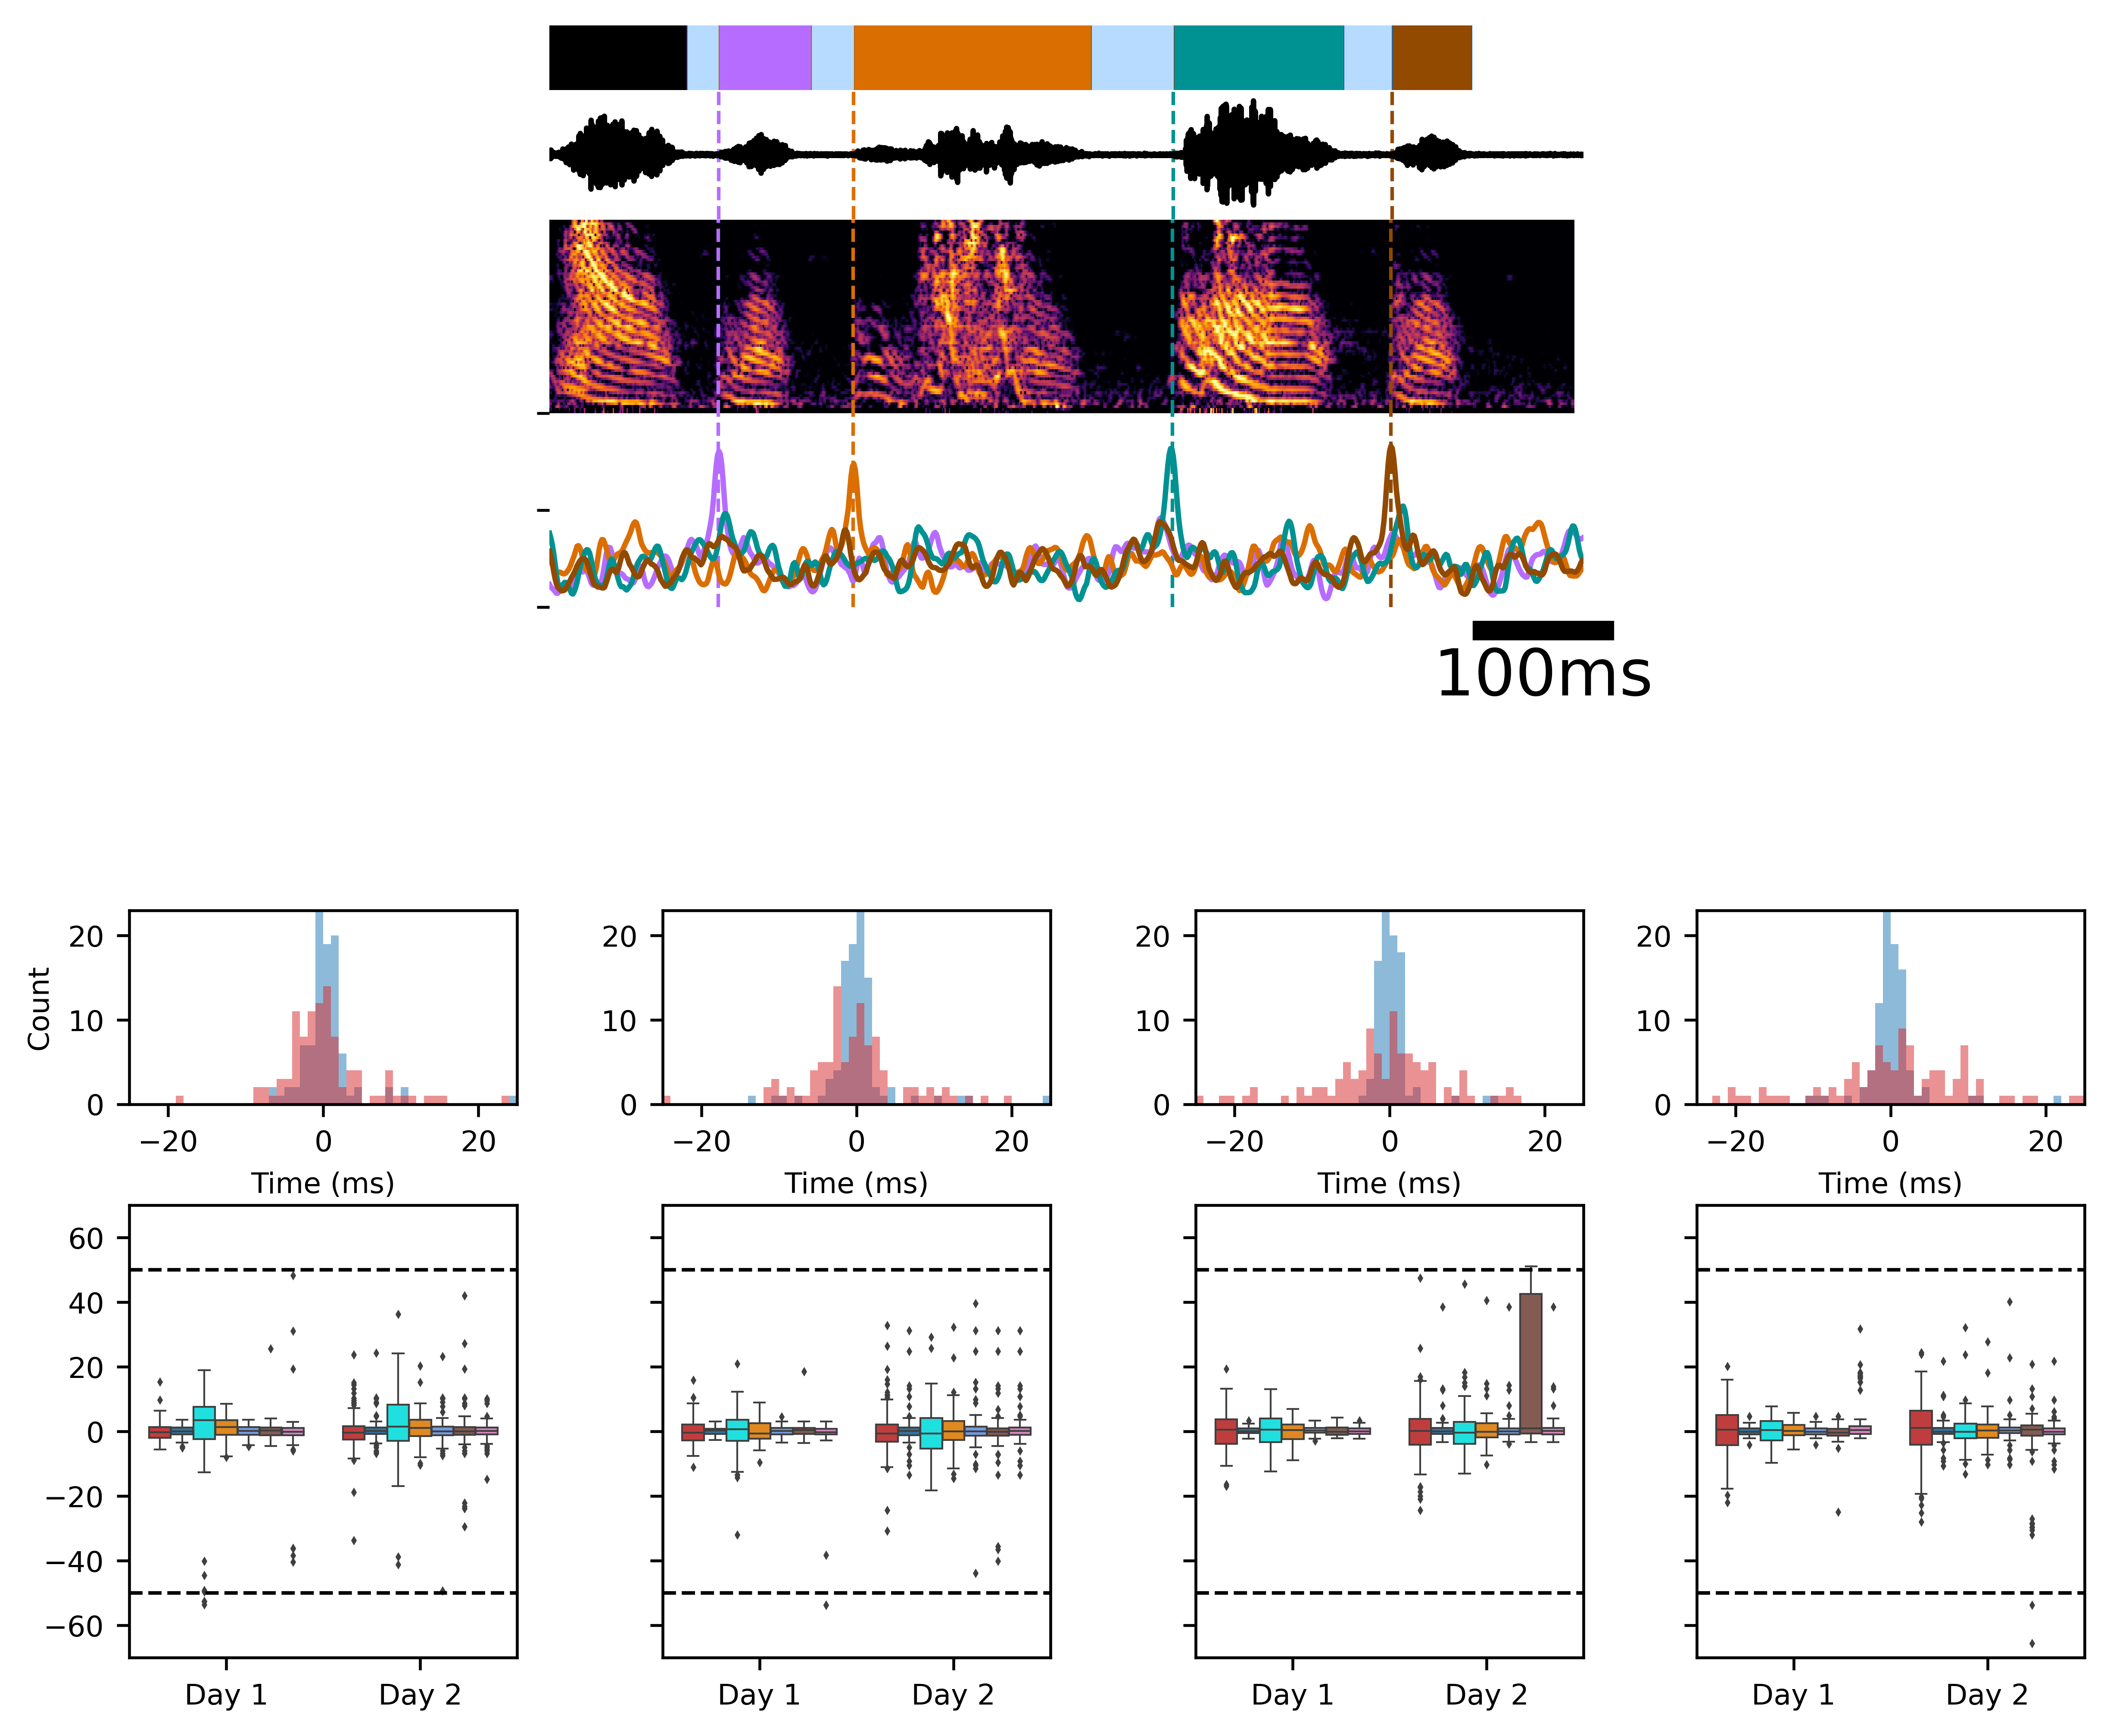

In [98]:
fig = plt.figure(figsize=(8.5, 7), dpi = 300)

freq_colors = [ 'tab:red', 'tab:blue', 'aqua', 'darkorange', 'cornflowerblue', 'tab:brown', 'tab:pink']


# Make the Subplots

# Exemplar Plot
predict_ax = fig.add_axes([0.2647058, 0.651787, 0.47058824, 0.10714], frame_on=False, xticklabels=[], ylim=(0, 1))
spect_ax = fig.add_axes([0.2647058, 0.7589298, 0.47058824, 0.10714], frame_on=False, xticklabels=[], ylim=(-1.2, 1.2))
pressure_ax = fig.add_axes([0.2647058, 0.86607, 0.47058824, 0.07142857], frame_on=False, xticklabels=[], ylim=(-1.2, 1.2))
label_ax = fig.add_axes([0.2647058, 0.93749857, 0.47058824, 0.03571429], frame_on=False, xticklabels=[]) #, ylim=(-1.2, 1.2))
# [left, bottom, width, height]


# Legend
# legend_ax = fig.add_axes([0.79411757, 0.5231091, 0.14705822, 0.21428571]) # Used to Calculate the Location

# Syllabel 2
syll_2_1 = fig.add_axes([0.07352941, 0.07142, 0.17647, 0.25]) # old height = 0.21428571
syll_2_2 = fig.add_axes([0.07352941, 0.37714557, 0.17647, 0.10714])

# Syllabel 3
syll_3_1 = fig.add_axes([0.31617258, 0.07142, 0.17647, 0.25])
syll_3_2 = fig.add_axes([0.31617258, 0.37714557, 0.17647, 0.10714])

# # Syllabel 4
syll_4_1 = fig.add_axes([0.55881929, 0.07142, 0.17647, 0.25])
syll_4_2 = fig.add_axes([0.55881929, 0.37714557, 0.17647, 0.10714])

# # Syllabel 5
syll_5_1 = fig.add_axes([0.78676013, 0.07142, 0.17647, 0.25])
syll_5_2 = fig.add_axes([0.78676013, 0.37714557, 0.17647, 0.10714])
####################################################################

# Make Plot of Behavior
repeated_behave = repeat_motif_events(labels_array= sel_behave, set_width= 400)
label_ax.imshow(repeated_behave, cmap=cmap2, Norm=norm, aspect="auto")

# ax1.set_xlim(0,.9)


for start, label in zip(sel_rel_starts, [2,3,4,5, 6, 7]):
        color = colors[label]
#         print(start)
#         print(start/30000)
        pressure_ax.axvline(x=start/30000, linestyle='--', color=color, linewidth=line_width*2)
        predict_ax.axvline(x=start/30, linestyle='--', color=color, linewidth=line_width*2)
        spect_ax.axvline(x=start/30, linestyle='--', color=color, linewidth=line_width*2)
        
label_ax.get_yaxis().set_visible(False)  # Hide the Y axis
label_ax.get_xaxis().set_visible(False)  # Hide the Y axis

# Audio Pressure Waveform
timeseries_audio = sel_audio/np.max(sel_audio)
timeseries_length = len(timeseries_audio)/30000  # Convert x to seconds
pressure_ax.plot(np.arange(0, timeseries_length, 1/30000), timeseries_audio, color = "black")
pressure_ax.get_yaxis().set_visible(False)  # Hide the Y axis
pressure_ax.get_xaxis().set_visible(False)  # Hide the Y axis
    
pressure_ax.set_xlim(0,.75)


# Plot the Spectrogram
sns.heatmap(s2, xticklabels=False, yticklabels= False, cbar = False, cmap= 'inferno', ax = spect_ax)
spect_ax.invert_yaxis()
spect_ax.set_ylim((0,70))
spect_ax.set_xlim(0, 751)


for predict_slam, color in zip(exemplar_predictions, ['#B66DFF','#db6e00','#009292','#924900','#006DDB','#FFFF6D']):
    predict_ax.plot(np.arange(751), predict_slam/max_confidence, color = color)

predict_ax.set_ylim(0, 1)
predict_ax.set_xlim(0, 751)
# predict_ax.get_yaxis().set_visible(False)  # Hide the Y axis
predict_ax.set_yticklabels([])
predict_ax.get_xaxis().set_visible(False)  # Hide the Y axis


# Add a Scale Bar
scalebar = AnchoredSizeBar(pressure_ax.transData,
                           .1, '100ms', 'center right', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=.3,
                           fontproperties=fontprops, bbox_to_anchor=(1.08, -.3),
                           bbox_transform=predict_ax.transAxes)


predict_ax.add_artist(scalebar)

# Syllabel 2
## Box Plot
# sns.boxplot(x="Bird ID", y="times", hue="Freq_band",
#             hue_order=['Stereotyped', 'All', '4-8', '8-12', '25-35', '30-50', '50-70'],
#             data=full_results[full_results["Syllable"]==2], 
#             order=['z007', 'z020', 'z017'],
#             palette = freq_colors,
#             fliersize=line_width, 
#             linewidth=line_width, 
#             ax=syll_2_1)  # hue="Freq_band"

sns.boxplot(x="session", y="times", hue="Freq_band",
            hue_order=['Stereotyped', 'All', '4-8', '8-12', '25-35', '30-50', '50-70'],
            data=full_results_z007[full_results_z007["Syllable"]==2], 
            order=['Day 1','Day 2'],
            palette = freq_colors,
            fliersize=line_width, 
            linewidth=line_width, 
            ax=syll_2_1)  # hue="Freq_band"

syll_2_1.set_ylim(-70, 70)
syll_2_1.axhline(y = 50, color= 'black', ls='--', linewidth=1)
syll_2_1.axhline(y = -50, color= 'black', ls='--', linewidth=1)


syll_2_1.set_ylabel('Time Relative to True Onset (ms)')
syll_2_1.tick_params(axis='both', which='major', labelsize=ticksize)
# ax1.set_xticklabels([])
# syll_2_1.set_yticklabels([])
syll_2_1.xaxis.label.set_visible(False)
syll_2_1.yaxis.label.set_visible(False)

# overall_legend = syll_2_1.get_legend()
# syll_2_1.legend(loc= 'lower left', bbox_to_anchor=(3.5714514624882217, 1.9781850075637004, 1, 1))
syll_2_1.legend('',frameon=False)



## Timing Distribution
fixed_predict_starts = collaspse_folds(z007_election_results[0])
fixed_stereo_starts = collaspse_folds(z007_stereotyped_starts[0][0])
syll_2_2.hist(np.asarray(fixed_predict_starts), bins=time_buffer * 2, range=(-time_buffer, time_buffer),
        label='prediction', alpha=.5, color=freq_colors[1])
syll_2_2.hist(np.asarray(fixed_stereo_starts), bins=time_buffer * 2, range=(-time_buffer, time_buffer),
        label='stereotyped', alpha=.5, color=freq_colors[0])

syll_2_2.set_xlabel(xlabel='Time (ms)', fontsize=subsize)
syll_2_2.set_ylabel(ylabel='Count', fontsize=subsize)
syll_2_2.tick_params(axis='both', which='major', labelsize=ticksize)
syll_2_2.set_xlim(-time_buffer/2, time_buffer/2)
syll_2_2.set_ylim(0, 23)


# Syllabel 3
## Box Plot
# sns.boxplot(x="Bird ID", y="times", hue="Freq_band",
#             hue_order=['Stereotyped', 'All', '4-8', '8-12', '25-35', '30-50', '50-70'],
#             data=full_results[full_results["Syllable"]==3], 
#             order=['z007', 'z020', 'z017'], 
#             palette = freq_colors,
#             fliersize=line_width, 
#             linewidth=line_width, 
#             ax=syll_3_1)  # hue="Freq_band"

sns.boxplot(x="session", y="times", hue="Freq_band",
            hue_order=['Stereotyped', 'All', '4-8', '8-12', '25-35', '30-50', '50-70'],
            data=full_results_z007[full_results_z007["Syllable"]==3], 
            order=['Day 1','Day 2'], 
            palette = freq_colors,
            fliersize=line_width, 
            linewidth=line_width, 
            ax=syll_3_1)  # hue="Freq_band"

syll_3_1.set_ylim(-70, 70)
syll_3_1.axhline(y = 50, color= 'black', ls='--', linewidth=1)
syll_3_1.axhline(y = -50, color= 'black', ls='--', linewidth=1)


syll_3_1.set_ylabel('Time Relative to True Onset (ms)')
syll_3_1.tick_params(axis='both', which='major', labelsize=ticksize)
# ax1.set_xticklabels([])
syll_3_1.set_yticklabels([])
syll_3_1.xaxis.label.set_visible(False)
syll_3_1.yaxis.label.set_visible(False)

syll_3_1.legend('',frameon=False)


## Timing Distribution
fixed_predict_starts = collaspse_folds(z007_election_results[1])
fixed_stereo_starts = collaspse_folds(z007_stereotyped_starts[1][0])
syll_3_2.hist(np.asarray(fixed_predict_starts), bins=time_buffer * 2, range=(-time_buffer, time_buffer),
        label='prediction', alpha=.5, color=freq_colors[1])
syll_3_2.hist(np.asarray(fixed_stereo_starts), bins=time_buffer * 2, range=(-time_buffer, time_buffer),
        label='stereotyped', alpha=.5, color=freq_colors[0])

syll_3_2.set_xlabel(xlabel='Time (ms)', fontsize=subsize)
# syll_3_2.set_ylabel(ylabel='Count', fontsize=subsize)
syll_3_2.tick_params(axis='both', which='major', labelsize=ticksize)
syll_3_2.set_xlim(-time_buffer/2, time_buffer/2)
syll_3_2.set_ylim(0, 23)


# Syllabel 4
## Box Plot
# sns.boxplot(x="Bird ID", y="times", hue="Freq_band",
#             hue_order=['Stereotyped', 'All', '4-8', '8-12', '25-35', '30-50', '50-70'],
#             data=full_results[full_results["Syllable"]==4], 
#             order=['z007', 'z020', 'z017'], 
#             palette = freq_colors,
#             fliersize=line_width, 
#             linewidth=line_width, 
#             ax=syll_4_1)  # hue="Freq_band"

sns.boxplot(x="session", y="times", hue="Freq_band",
            hue_order=['Stereotyped', 'All', '4-8', '8-12', '25-35', '30-50', '50-70'],
            data=full_results_z007[full_results_z007["Syllable"]==4], 
            order=['Day 1','Day 2'], 
            palette = freq_colors,
            fliersize=line_width, 
            linewidth=line_width, 
            ax=syll_4_1)  # hue="Freq_band"


syll_4_1.set_ylim(-70, 70)
syll_4_1.axhline(y = 50, color= 'black', ls='--', linewidth=1)
syll_4_1.axhline(y = -50, color= 'black', ls='--', linewidth=1)


syll_4_1.set_ylabel('Time Relative to True Onset (ms)')
syll_4_1.tick_params(axis='both', which='major', labelsize=ticksize)
# ax1.set_xticklabels([])
syll_4_1.set_yticklabels([])
syll_4_1.xaxis.label.set_visible(False)
syll_4_1.yaxis.label.set_visible(False)

syll_4_1.legend('',frameon=False)


## Timing Distribution
fixed_predict_starts = collaspse_folds(z007_election_results[2])
fixed_stereo_starts = collaspse_folds(z007_stereotyped_starts[2][0])
syll_4_2.hist(np.asarray(fixed_predict_starts), bins=time_buffer * 2, range=(-time_buffer, time_buffer),
        label='prediction', alpha=.5, color=freq_colors[1])
syll_4_2.hist(np.asarray(fixed_stereo_starts), bins=time_buffer * 2, range=(-time_buffer, time_buffer),
        label='stereotyped', alpha=.5, color=freq_colors[0])

syll_4_2.set_xlabel(xlabel='Time (ms)', fontsize=subsize)
# syll_4_2.set_ylabel(ylabel='Count', fontsize=subsize)
syll_4_2.tick_params(axis='both', which='major', labelsize=ticksize)
syll_4_2.set_xlim(-time_buffer/2, time_buffer/2)
syll_4_2.set_ylim(0, 23)


# Syllabel 5
## Box Plot
# sns.boxplot(x="Bird ID", y="times", hue="Freq_band",
#             hue_order=['Stereotyped', 'All', '4-8', '8-12', '25-35', '30-50', '50-70'],
#             data=full_results[full_results["Syllable"]==5], 
#             order=['z007', 'z017'], 
#             palette = freq_colors,
#             fliersize=line_width, 
#             linewidth=line_width, 
#             ax=syll_5_1)  # hue="Freq_band"

sns.boxplot(x="session", y="times", hue="Freq_band",
            hue_order=['Stereotyped', 'All', '4-8', '8-12', '25-35', '30-50', '50-70'],
            data=full_results_z007[full_results_z007["Syllable"]==5], 
            order=['Day 1','Day 2'], 
            palette = freq_colors,
            fliersize=line_width, 
            linewidth=line_width, 
            ax=syll_5_1)  # hue="Freq_band"

syll_5_1.set_ylim(-70, 70)
syll_5_1.axhline(y = 50, color= 'black', ls='--', linewidth=1)
syll_5_1.axhline(y = -50, color= 'black', ls='--', linewidth=1)


syll_5_1.set_ylabel('Time Relative to True Onset (ms)')
syll_5_1.tick_params(axis='both', which='major', labelsize=ticksize)
# ax1.set_xticklabels([])
syll_5_1.set_yticklabels([])
syll_5_1.xaxis.label.set_visible(False)
syll_5_1.yaxis.label.set_visible(False)

syll_5_1.legend('',frameon=False)


## Timing Distribution
fixed_predict_starts = collaspse_folds(z007_election_results[3])
fixed_stereo_starts = collaspse_folds(z007_stereotyped_starts[3][0])
syll_5_2.hist(np.asarray(fixed_predict_starts), bins=time_buffer * 2, range=(-time_buffer, time_buffer),
        label='prediction', alpha=.5, color=freq_colors[1])
syll_5_2.hist(np.asarray(fixed_stereo_starts), bins=time_buffer * 2, range=(-time_buffer, time_buffer),
        label='stereotyped', alpha=.5, color=freq_colors[0])

syll_5_2.set_xlabel(xlabel='Time (ms)', fontsize=subsize)
# syll_5_2.set_ylabel(ylabel='Count', fontsize=subsize)
syll_5_2.tick_params(axis='both', which='major', labelsize=ticksize)
syll_5_2.set_xlim(-time_buffer/2, time_buffer/2)
syll_5_2.set_ylim(0, 23)


# Fill in Background of Select Plots (For Contrast)

pressure_min, pressure_max = pressure_ax.get_ylim()
pressure_left, pressure_right = pressure_ax.get_xlim()
pressure_ax.fill_between(x = np.arange(pressure_left, pressure_right, .001), y1=pressure_min, y2=pressure_max, color = 'white')


# # Save the Figure
# figure_name = 'Onset_prediction' + 'z007_cb.svg'
# figure_type_folder = FIGURES_DIR / 'Branch_Analysis'

# # Check if Folder Path Exists
# if not figure_type_folder.exists():
#     figure_type_folder.mkdir(parents=True, exist_ok=True)

# figure_location = figure_type_folder / figure_name

# # fig.savefig(figure_location, format='png')
# fig.savefig(figure_location, dpi=300, papertype=None, format='svg')





plt.show()


In [83]:
np.shape(s2)

(101, 744)

In [84]:
np.sum(s2>.5)

9448

In [ ]:
## Timing Distribution
fixed_predict_starts = collaspse_folds(z007_election_results[3])
fixed_stereo_starts = collaspse_folds(z007_stereotyped_starts[3][0])
syll_5_2.hist(np.asarray(fixed_predict_starts), bins=time_buffer * 2, range=(-time_buffer, time_buffer),
        label='prediction', alpha=.5, color=freq_colors[1])
syll_5_2.hist(np.asarray(fixed_stereo_starts), bins=time_buffer * 2, range=(-time_buffer, time_buffer),
        label='stereotyped', alpha=.5, color=freq_colors[0])

syll_5_2.set_xlabel(xlabel='Time (ms)', fontsize=subsize)
# syll_5_2.set_ylabel(ylabel='Count', fontsize=subsize)
syll_5_2.tick_params(axis='both', which='major', labelsize=ticksize)
syll_5_2.set_xlim(-time_buffer/2, time_buffer/2)
syll_5_2.set_ylim(0, 23)

In [99]:

results_holder = []
for sel_results, state in zip([fixed_predict_starts, fixed_stereo_starts], ["prediction", "stereotyped"]):
#     sel_results = collaspse_folds(syll)
    sel_results_df = pd.DataFrame(sel_results, columns=['Time (ms)'])  # Make the DataFrame
    sel_results_df['State'] = state
#     sel_results_df['Syllable'] = label_instruct[syll_num]

    results_holder.append(sel_results_df)
onset_pd_syll = pd.concat(results_holder, axis=0)


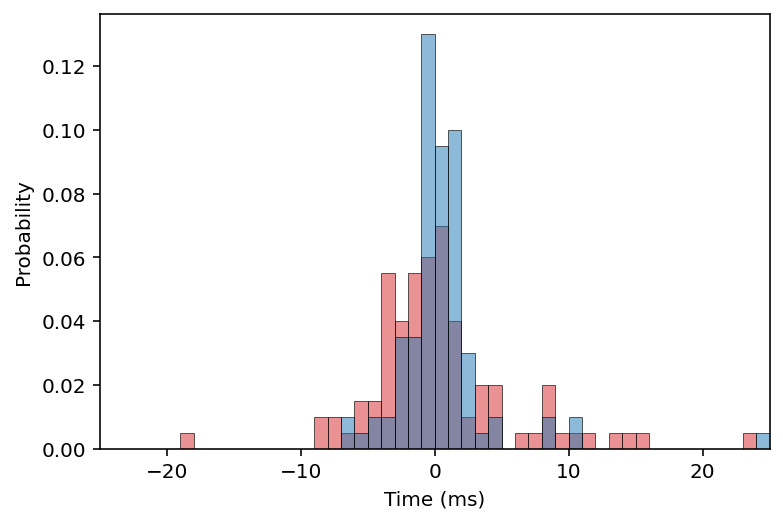

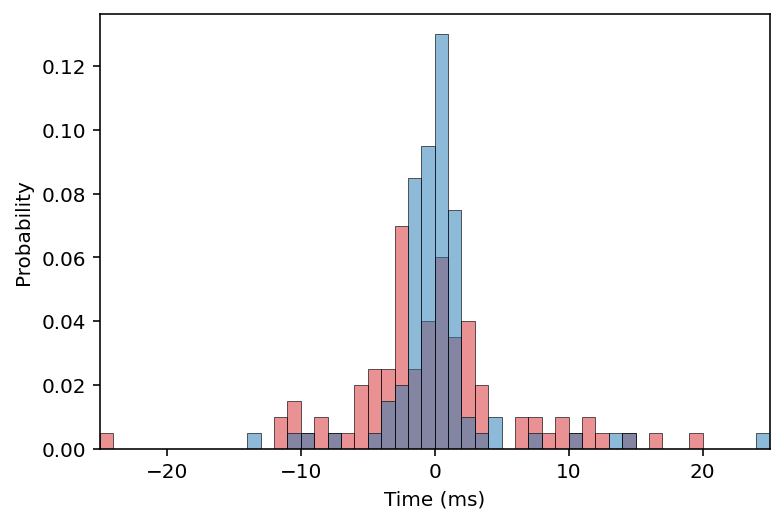

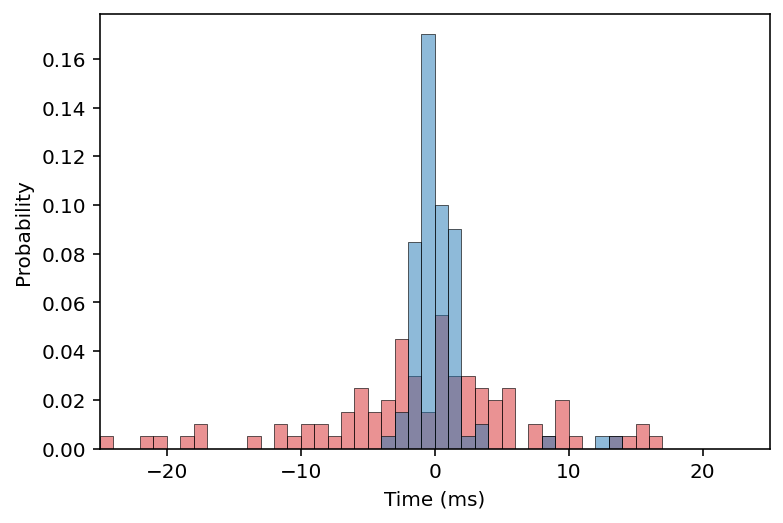

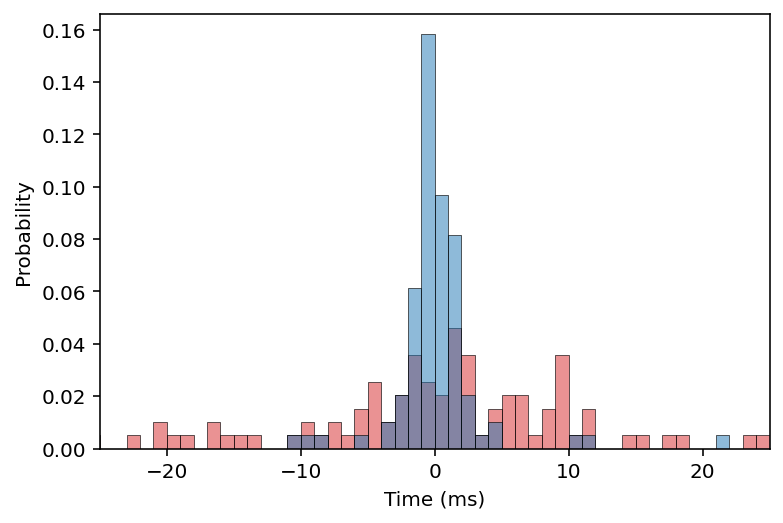

In [119]:

for i in range(4):
    plt.figure()
    fixed_predict_starts = collaspse_folds(z007_election_results[i])
    fixed_stereo_starts = collaspse_folds(z007_stereotyped_starts[i][0])

    results_holder = []
    for sel_results, state in zip([fixed_predict_starts, fixed_stereo_starts], ["prediction", "stereotyped"]):
        sel_results_df = pd.DataFrame(sel_results, columns=['Time (ms)'])  # Make the DataFrame
        sel_results_df['State'] = state
        results_holder.append(sel_results_df)
    onset_pd_syll = pd.concat(results_holder, axis=0)


    sns.histplot(onset_pd_syll, x='Time (ms)', hue_order=["prediction", "stereotyped"],   hue="State", bins=time_buffer * 2, stat="probability",  binrange=(-time_buffer, time_buffer), palette= [freq_colors[1], freq_colors[0]] )
    plt.xlim(-time_buffer/2, time_buffer/2)
    plt.legend('',frameon=False)
    plt.xlim(-time_buffer/2, time_buffer/2)


    plt.show

/home/debrown/anaconda3/envs/mne/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/home/debrown/anaconda3/envs/mne/lib/python3.7/site-packages/ipykernel_launcher.py:405: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later


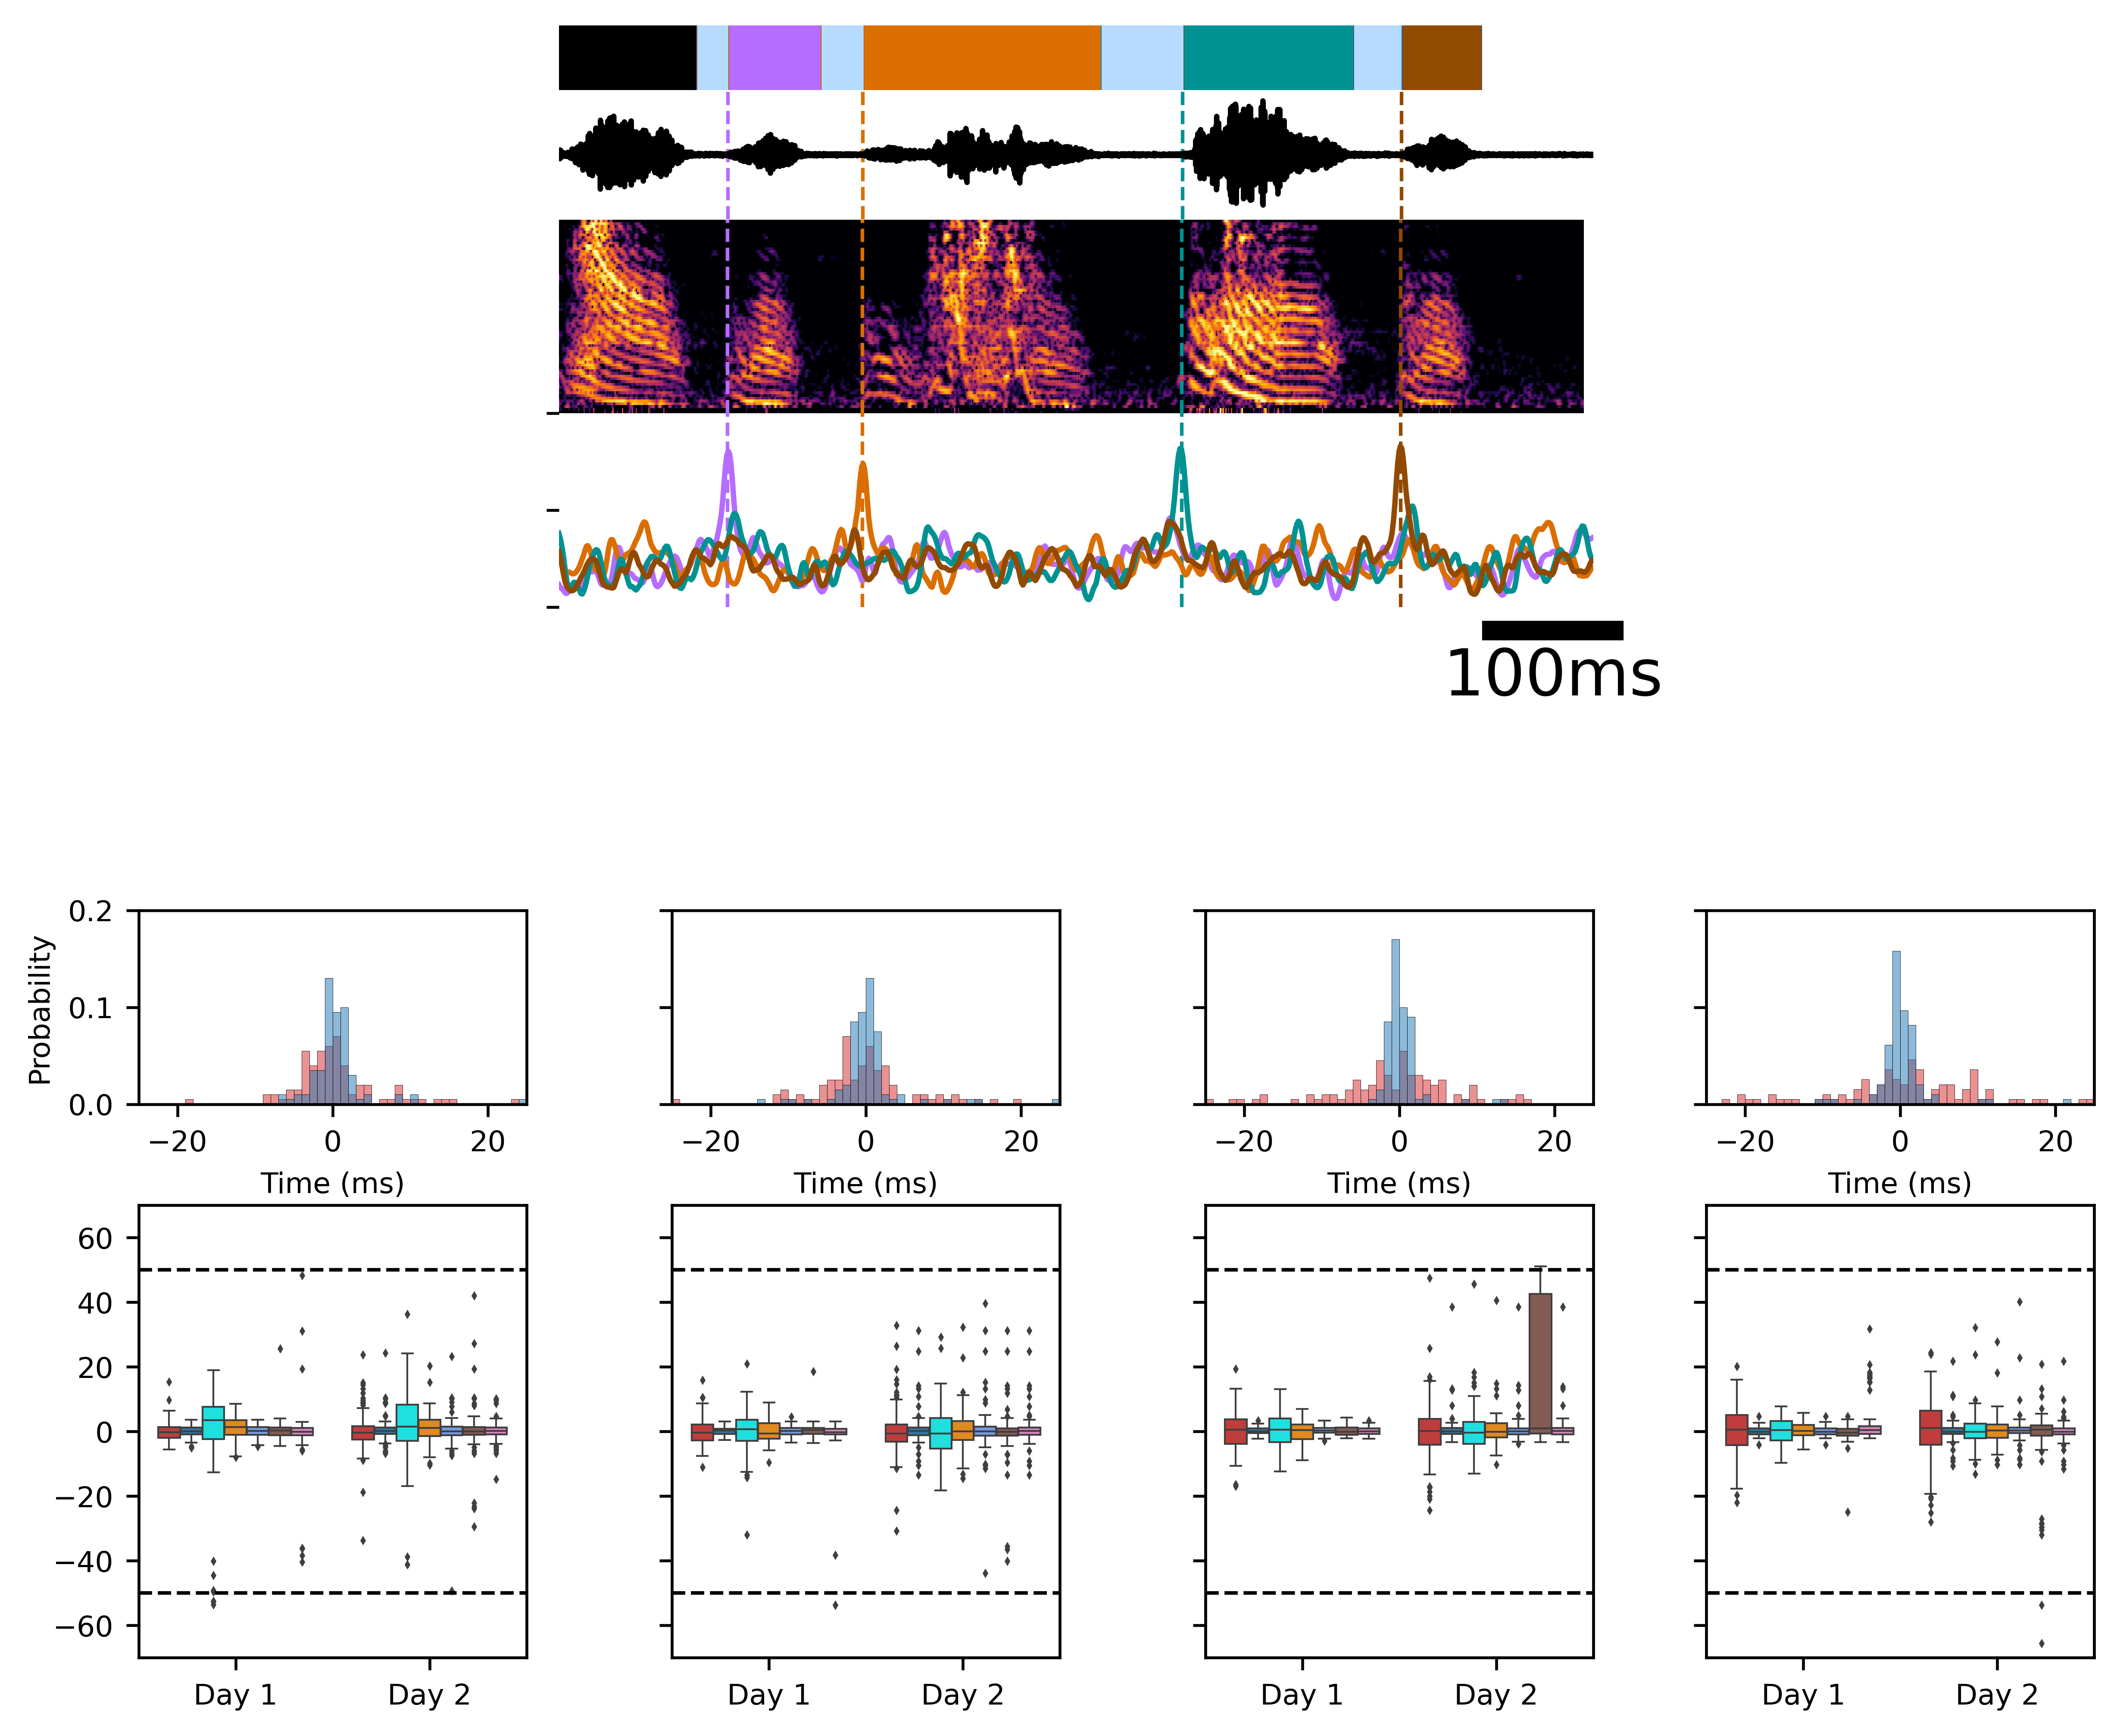

In [126]:
fig = plt.figure(figsize=(8.5, 7), dpi = 300)

freq_colors = [ 'tab:red', 'tab:blue', 'aqua', 'darkorange', 'cornflowerblue', 'tab:brown', 'tab:pink']


# Make the Subplots

# Exemplar Plot
predict_ax = fig.add_axes([0.2647058, 0.651787, 0.47058824, 0.10714], frame_on=False, xticklabels=[], ylim=(0, 1))
spect_ax = fig.add_axes([0.2647058, 0.7589298, 0.47058824, 0.10714], frame_on=False, xticklabels=[], ylim=(-1.2, 1.2))
pressure_ax = fig.add_axes([0.2647058, 0.86607, 0.47058824, 0.07142857], frame_on=False, xticklabels=[], ylim=(-1.2, 1.2))
label_ax = fig.add_axes([0.2647058, 0.93749857, 0.47058824, 0.03571429], frame_on=False, xticklabels=[]) #, ylim=(-1.2, 1.2))
# [left, bottom, width, height]


# Legend
# legend_ax = fig.add_axes([0.79411757, 0.5231091, 0.14705822, 0.21428571]) # Used to Calculate the Location

# Syllabel 2
syll_2_1 = fig.add_axes([0.07352941, 0.07142, 0.17647, 0.25]) # old height = 0.21428571
syll_2_2 = fig.add_axes([0.07352941, 0.37714557, 0.17647, 0.10714])

# Syllabel 3
syll_3_1 = fig.add_axes([0.31617258, 0.07142, 0.17647, 0.25])
syll_3_2 = fig.add_axes([0.31617258, 0.37714557, 0.17647, 0.10714])

# # Syllabel 4
syll_4_1 = fig.add_axes([0.55881929, 0.07142, 0.17647, 0.25])
syll_4_2 = fig.add_axes([0.55881929, 0.37714557, 0.17647, 0.10714])

# # Syllabel 5
syll_5_1 = fig.add_axes([0.78676013, 0.07142, 0.17647, 0.25])
syll_5_2 = fig.add_axes([0.78676013, 0.37714557, 0.17647, 0.10714])
####################################################################

# Make Plot of Behavior
repeated_behave = repeat_motif_events(labels_array= sel_behave, set_width= 400)
label_ax.imshow(repeated_behave, cmap=cmap2, Norm=norm, aspect="auto")

# ax1.set_xlim(0,.9)


for start, label in zip(sel_rel_starts, [2,3,4,5, 6, 7]):
        color = colors[label]
#         print(start)
#         print(start/30000)
        pressure_ax.axvline(x=start/30000, linestyle='--', color=color, linewidth=line_width*2)
        predict_ax.axvline(x=start/30, linestyle='--', color=color, linewidth=line_width*2)
        spect_ax.axvline(x=start/30, linestyle='--', color=color, linewidth=line_width*2)
        
label_ax.get_yaxis().set_visible(False)  # Hide the Y axis
label_ax.get_xaxis().set_visible(False)  # Hide the Y axis

# Audio Pressure Waveform
timeseries_audio = sel_audio/np.max(sel_audio)
timeseries_length = len(timeseries_audio)/30000  # Convert x to seconds
pressure_ax.plot(np.arange(0, timeseries_length, 1/30000), timeseries_audio, color = "black")
pressure_ax.get_yaxis().set_visible(False)  # Hide the Y axis
pressure_ax.get_xaxis().set_visible(False)  # Hide the Y axis
    
pressure_ax.set_xlim(0,.75)


# Plot the Spectrogram
sns.heatmap(s2, xticklabels=False, yticklabels= False, cbar = False, cmap= 'inferno', ax = spect_ax)
spect_ax.invert_yaxis()
spect_ax.set_ylim((0,70))
spect_ax.set_xlim(0, 751)


for predict_slam, color in zip(exemplar_predictions, ['#B66DFF','#db6e00','#009292','#924900','#006DDB','#FFFF6D']):
    predict_ax.plot(np.arange(751), predict_slam/max_confidence, color = color)

predict_ax.set_ylim(0, 1)
predict_ax.set_xlim(0, 751)
# predict_ax.get_yaxis().set_visible(False)  # Hide the Y axis
predict_ax.set_yticklabels([])
predict_ax.get_xaxis().set_visible(False)  # Hide the Y axis


# Add a Scale Bar
scalebar = AnchoredSizeBar(pressure_ax.transData,
                           .1, '100ms', 'center right', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=.3,
                           fontproperties=fontprops, bbox_to_anchor=(1.08, -.3),
                           bbox_transform=predict_ax.transAxes)


predict_ax.add_artist(scalebar)

# Syllabel 2
## Box Plot
# sns.boxplot(x="Bird ID", y="times", hue="Freq_band",
#             hue_order=['Stereotyped', 'All', '4-8', '8-12', '25-35', '30-50', '50-70'],
#             data=full_results[full_results["Syllable"]==2], 
#             order=['z007', 'z020', 'z017'],
#             palette = freq_colors,
#             fliersize=line_width, 
#             linewidth=line_width, 
#             ax=syll_2_1)  # hue="Freq_band"

sns.boxplot(x="session", y="times", hue="Freq_band",
            hue_order=['Stereotyped', 'All', '4-8', '8-12', '25-35', '30-50', '50-70'],
            data=full_results_z007[full_results_z007["Syllable"]==2], 
            order=['Day 1','Day 2'],
            palette = freq_colors,
            fliersize=line_width, 
            linewidth=line_width, 
            ax=syll_2_1)  # hue="Freq_band"

syll_2_1.set_ylim(-70, 70)
syll_2_1.axhline(y = 50, color= 'black', ls='--', linewidth=1)
syll_2_1.axhline(y = -50, color= 'black', ls='--', linewidth=1)


syll_2_1.set_ylabel('Time Relative to True Onset (ms)')
syll_2_1.tick_params(axis='both', which='major', labelsize=ticksize)
# ax1.set_xticklabels([])
# syll_2_1.set_yticklabels([])
syll_2_1.xaxis.label.set_visible(False)
syll_2_1.yaxis.label.set_visible(False)

# overall_legend = syll_2_1.get_legend()
# syll_2_1.legend(loc= 'lower left', bbox_to_anchor=(3.5714514624882217, 1.9781850075637004, 1, 1))
syll_2_1.legend('',frameon=False)



## Timing Distribution
fixed_predict_starts = collaspse_folds(z007_election_results[0])
fixed_stereo_starts = collaspse_folds(z007_stereotyped_starts[0][0])
# syll_2_2.hist(np.asarray(fixed_predict_starts), bins=time_buffer * 2, range=(-time_buffer, time_buffer),
#         label='prediction', alpha=.5, color=freq_colors[1])
# syll_2_2.hist(np.asarray(fixed_stereo_starts), bins=time_buffer * 2, range=(-time_buffer, time_buffer),
#         label='stereotyped', alpha=.5, color=freq_colors[0])

results_holder = []
for sel_results, state in zip([fixed_predict_starts, fixed_stereo_starts], ["prediction", "stereotyped"]):
#     sel_results = collaspse_folds(syll)
    sel_results_df = pd.DataFrame(sel_results, columns=['Time (ms)'])  # Make the DataFrame
    sel_results_df['State'] = state
#     sel_results_df['Syllable'] = label_instruct[syll_num]

    results_holder.append(sel_results_df)
onset_pd_syll = pd.concat(results_holder, axis=0)

sns.histplot(onset_pd_syll, x='Time (ms)', 
             hue_order=["prediction", "stereotyped"],   
             hue="State", 
             bins=time_buffer * 2, stat="probability",  
             binrange=(-time_buffer, time_buffer), 
             palette= [freq_colors[1], freq_colors[0]],
             ax= syll_2_2)

syll_2_2.legend('',frameon=False)

syll_2_2.set_xlabel(xlabel='Time (ms)', fontsize=subsize)
syll_2_2.set_ylabel(ylabel='Probability', fontsize=subsize)
syll_2_2.tick_params(axis='both', which='major', labelsize=ticksize)
syll_2_2.set_xlim(-time_buffer/2, time_buffer/2)
syll_2_2.set_ylim(0, .20)



# Syllabel 3
## Box Plot
# sns.boxplot(x="Bird ID", y="times", hue="Freq_band",
#             hue_order=['Stereotyped', 'All', '4-8', '8-12', '25-35', '30-50', '50-70'],
#             data=full_results[full_results["Syllable"]==3], 
#             order=['z007', 'z020', 'z017'], 
#             palette = freq_colors,
#             fliersize=line_width, 
#             linewidth=line_width, 
#             ax=syll_3_1)  # hue="Freq_band"

sns.boxplot(x="session", y="times", hue="Freq_band",
            hue_order=['Stereotyped', 'All', '4-8', '8-12', '25-35', '30-50', '50-70'],
            data=full_results_z007[full_results_z007["Syllable"]==3], 
            order=['Day 1','Day 2'], 
            palette = freq_colors,
            fliersize=line_width, 
            linewidth=line_width, 
            ax=syll_3_1)  # hue="Freq_band"

syll_3_1.set_ylim(-70, 70)
syll_3_1.axhline(y = 50, color= 'black', ls='--', linewidth=1)
syll_3_1.axhline(y = -50, color= 'black', ls='--', linewidth=1)


syll_3_1.set_ylabel('Time Relative to True Onset (ms)')
syll_3_1.tick_params(axis='both', which='major', labelsize=ticksize)
# ax1.set_xticklabels([])
syll_3_1.set_yticklabels([])
syll_3_1.xaxis.label.set_visible(False)
syll_3_1.yaxis.label.set_visible(False)

syll_3_1.legend('',frameon=False)


## Timing Distribution
fixed_predict_starts = collaspse_folds(z007_election_results[1])
fixed_stereo_starts = collaspse_folds(z007_stereotyped_starts[1][0])
# syll_3_2.hist(np.asarray(fixed_predict_starts), bins=time_buffer * 2, range=(-time_buffer, time_buffer),
#         label='prediction', alpha=.5, color=freq_colors[1])
# syll_3_2.hist(np.asarray(fixed_stereo_starts), bins=time_buffer * 2, range=(-time_buffer, time_buffer),
#         label='stereotyped', alpha=.5, color=freq_colors[0])

results_holder = []
for sel_results, state in zip([fixed_predict_starts, fixed_stereo_starts], ["prediction", "stereotyped"]):
#     sel_results = collaspse_folds(syll)
    sel_results_df = pd.DataFrame(sel_results, columns=['Time (ms)'])  # Make the DataFrame
    sel_results_df['State'] = state
#     sel_results_df['Syllable'] = label_instruct[syll_num]

    results_holder.append(sel_results_df)
onset_pd_syll = pd.concat(results_holder, axis=0)

sns.histplot(onset_pd_syll, x='Time (ms)', 
             hue_order=["prediction", "stereotyped"],   
             hue="State", 
             bins=time_buffer * 2, stat="probability",  
             binrange=(-time_buffer, time_buffer), 
             palette= [freq_colors[1], freq_colors[0]],
             ax= syll_3_2)

syll_3_2.legend('',frameon=False)

syll_3_2.set_xlabel(xlabel='Time (ms)', fontsize=subsize)
# syll_3_2.set_ylabel(ylabel='Count', fontsize=subsize)
syll_3_2.tick_params(axis='both', which='major', labelsize=ticksize)
syll_3_2.set_xlim(-time_buffer/2, time_buffer/2)
syll_3_2.set_ylim(0, .20)

syll_3_2.set_yticklabels([])
syll_3_2.yaxis.label.set_visible(False)


# Syllabel 4
## Box Plot
# sns.boxplot(x="Bird ID", y="times", hue="Freq_band",
#             hue_order=['Stereotyped', 'All', '4-8', '8-12', '25-35', '30-50', '50-70'],
#             data=full_results[full_results["Syllable"]==4], 
#             order=['z007', 'z020', 'z017'], 
#             palette = freq_colors,
#             fliersize=line_width, 
#             linewidth=line_width, 
#             ax=syll_4_1)  # hue="Freq_band"

sns.boxplot(x="session", y="times", hue="Freq_band",
            hue_order=['Stereotyped', 'All', '4-8', '8-12', '25-35', '30-50', '50-70'],
            data=full_results_z007[full_results_z007["Syllable"]==4], 
            order=['Day 1','Day 2'], 
            palette = freq_colors,
            fliersize=line_width, 
            linewidth=line_width, 
            ax=syll_4_1)  # hue="Freq_band"


syll_4_1.set_ylim(-70, 70)
syll_4_1.axhline(y = 50, color= 'black', ls='--', linewidth=1)
syll_4_1.axhline(y = -50, color= 'black', ls='--', linewidth=1)


syll_4_1.set_ylabel('Time Relative to True Onset (ms)')
syll_4_1.tick_params(axis='both', which='major', labelsize=ticksize)
# ax1.set_xticklabels([])
syll_4_1.set_yticklabels([])
syll_4_1.xaxis.label.set_visible(False)
syll_4_1.yaxis.label.set_visible(False)

syll_4_1.legend('',frameon=False)


## Timing Distribution
fixed_predict_starts = collaspse_folds(z007_election_results[2])
fixed_stereo_starts = collaspse_folds(z007_stereotyped_starts[2][0])
# syll_4_2.hist(np.asarray(fixed_predict_starts), bins=time_buffer * 2, range=(-time_buffer, time_buffer),
#         label='prediction', alpha=.5, color=freq_colors[1])
# syll_4_2.hist(np.asarray(fixed_stereo_starts), bins=time_buffer * 2, range=(-time_buffer, time_buffer),
#         label='stereotyped', alpha=.5, color=freq_colors[0])

results_holder = []
for sel_results, state in zip([fixed_predict_starts, fixed_stereo_starts], ["prediction", "stereotyped"]):
#     sel_results = collaspse_folds(syll)
    sel_results_df = pd.DataFrame(sel_results, columns=['Time (ms)'])  # Make the DataFrame
    sel_results_df['State'] = state
#     sel_results_df['Syllable'] = label_instruct[syll_num]

    results_holder.append(sel_results_df)
onset_pd_syll = pd.concat(results_holder, axis=0)

sns.histplot(onset_pd_syll, x='Time (ms)', 
             hue_order=["prediction", "stereotyped"],   
             hue="State", 
             bins=time_buffer * 2, stat="probability",  
             binrange=(-time_buffer, time_buffer), 
             palette= [freq_colors[1], freq_colors[0]],
             ax= syll_4_2)

syll_4_2.legend('',frameon=False)

syll_4_2.set_xlabel(xlabel='Time (ms)', fontsize=subsize)
# syll_4_2.set_ylabel(ylabel='Count', fontsize=subsize)
syll_4_2.tick_params(axis='both', which='major', labelsize=ticksize)
syll_4_2.set_xlim(-time_buffer/2, time_buffer/2)
syll_4_2.set_ylim(0, .20)

syll_4_2.set_yticklabels([])
syll_4_2.yaxis.label.set_visible(False)

# Syllabel 5
## Box Plot
# sns.boxplot(x="Bird ID", y="times", hue="Freq_band",
#             hue_order=['Stereotyped', 'All', '4-8', '8-12', '25-35', '30-50', '50-70'],
#             data=full_results[full_results["Syllable"]==5], 
#             order=['z007', 'z017'], 
#             palette = freq_colors,
#             fliersize=line_width, 
#             linewidth=line_width, 
#             ax=syll_5_1)  # hue="Freq_band"

sns.boxplot(x="session", y="times", hue="Freq_band",
            hue_order=['Stereotyped', 'All', '4-8', '8-12', '25-35', '30-50', '50-70'],
            data=full_results_z007[full_results_z007["Syllable"]==5], 
            order=['Day 1','Day 2'], 
            palette = freq_colors,
            fliersize=line_width, 
            linewidth=line_width, 
            ax=syll_5_1)  # hue="Freq_band"

syll_5_1.set_ylim(-70, 70)
syll_5_1.axhline(y = 50, color= 'black', ls='--', linewidth=1)
syll_5_1.axhline(y = -50, color= 'black', ls='--', linewidth=1)


syll_5_1.set_ylabel('Time Relative to True Onset (ms)')
syll_5_1.tick_params(axis='both', which='major', labelsize=ticksize)
# ax1.set_xticklabels([])
syll_5_1.set_yticklabels([])
syll_5_1.xaxis.label.set_visible(False)
syll_5_1.yaxis.label.set_visible(False)

syll_5_1.legend('',frameon=False)


## Timing Distribution
fixed_predict_starts = collaspse_folds(z007_election_results[3])
fixed_stereo_starts = collaspse_folds(z007_stereotyped_starts[3][0])
# syll_5_2.hist(np.asarray(fixed_predict_starts), bins=time_buffer * 2, range=(-time_buffer, time_buffer),
#         label='prediction', alpha=.5, color=freq_colors[1])
# syll_5_2.hist(np.asarray(fixed_stereo_starts), bins=time_buffer * 2, range=(-time_buffer, time_buffer),
#         label='stereotyped', alpha=.5, color=freq_colors[0])

results_holder = []
for sel_results, state in zip([fixed_predict_starts, fixed_stereo_starts], ["prediction", "stereotyped"]):
#     sel_results = collaspse_folds(syll)
    sel_results_df = pd.DataFrame(sel_results, columns=['Time (ms)'])  # Make the DataFrame
    sel_results_df['State'] = state
#     sel_results_df['Syllable'] = label_instruct[syll_num]

    results_holder.append(sel_results_df)
onset_pd_syll = pd.concat(results_holder, axis=0)

sns.histplot(onset_pd_syll, x='Time (ms)', 
             hue_order=["prediction", "stereotyped"],   
             hue="State", 
             bins=time_buffer * 2, stat="probability",  
             binrange=(-time_buffer, time_buffer), 
             palette= [freq_colors[1], freq_colors[0]],
             ax= syll_5_2)

syll_5_2.legend('',frameon=False)

syll_5_2.set_xlabel(xlabel='Time (ms)', fontsize=subsize)
# syll_5_2.set_ylabel(ylabel='Count', fontsize=subsize)
syll_5_2.tick_params(axis='both', which='major', labelsize=ticksize)
syll_5_2.set_xlim(-time_buffer/2, time_buffer/2)
syll_5_2.set_ylim(0, .20)

syll_5_2.set_yticklabels([])
syll_5_2.yaxis.label.set_visible(False)


# Fill in Background of Select Plots (For Contrast)

pressure_min, pressure_max = pressure_ax.get_ylim()
pressure_left, pressure_right = pressure_ax.get_xlim()
pressure_ax.fill_between(x = np.arange(pressure_left, pressure_right, .001), y1=pressure_min, y2=pressure_max, color = 'white')


# # Save the Figure
# figure_name = 'Onset_prediction' + 'z007_cb_probability.svg'
# figure_type_folder = FIGURES_DIR / 'Branch_Analysis'

# # Check if Folder Path Exists
# if not figure_type_folder.exists():
#     figure_type_folder.mkdir(parents=True, exist_ok=True)

# figure_location = figure_type_folder / figure_name

# # fig.savefig(figure_location, format='png')
# fig.savefig(figure_location, dpi=300, papertype=None, format='svg')





plt.show()
